## This Notebook generates the plots in Figure 7. It runs on a Julia 1.7-1.9 kernel.
To use this script, you will need to download the following scripts and data files first:
- DK_analysis_functions.jl
- copy_kmeans.jl
- NeuroPAL_labels_dict.jld2
- nsm_analysis_dict_swf702_final.jld2
- 5htr_expression_dv_final.csv
- witvliet_2020_7.json
- witvliet_2020_8.json
- white_1986_whole.json


You can use the same code to visualize data about SWF415, which lacks information on neuron identity. Analysis results for SWF415 is stored in: 
- nsm_analysis_dict_swf415_v3.jld2

## Load all packages and data

In [15]:
# flavell-lab specific packages
# available on https://github.com/flavell-lab
using NeuroPALData

In [2]:
# general opensource packages
using JLD2, JSON, PyCall, StatsPlots, CSV, DataFrames, Clustering, GLM, Polynomials, MultipleTesting

In [171]:
# load scipy toolbox
@pyimport scipy.stats as stats

In [1164]:
# modify this path to where you saved DK_analysis_functions.jl
path_dk_analysis = "/home/candy/Notebook_prj_5ht/DK_analysis_functions.jl"
include(path_dk_analysis);

In [ ]:
# modify this path to where you saved copy_kmeans.jl
path_dk_clustering = "/home/candy/Notebook_prj_5ht/copy_kmeans.jl"
include("/home/candy/Notebook_prj_5ht/copy_kmeans.jl");

In [436]:
# modify this path to where you saved NeuroPAL_labels_dict.jld2
# this is a Julia-specific file type that saves the manually labelled neuron identity matched to registered ROIs
path_id_dict = "/data1/prj_5ht/DK_analysis_output/NeuroPAL_labels_dict.jld2"
if isfile(path_id_dict)
    f = JLD2.jldopen(path_id_dict)
    NeuroPAL_labels = f["NeuroPAL_labels"]
    close(f)
end

list_class_any = NeuroPAL_labels["list_class_any"]
list_class_any_dv = NeuroPAL_labels["list_class_any_dv"];

In [129]:
# modify this path to where you saved nsm_analysis_dict_swf702_final.jld2
# this is a Julia-specific file type that saves the relationship of each registered neuron with NSM
path_nsm_analysis_dict = "/data1/prj_5ht/data_processed_neuropal/nsm_analysis_dict_swf702_final.jld2"
if isfile(path_nsm_analysis_dict)
    f = JLD2.jldopen(path_nsm_analysis_dict)
    nsm_analysis_dict = f["nsm_analysis_dict"]
    close(f)
end

In [549]:
# modify this path to where you saved 5htr_expression.csv
# this table summarizes the expression profile for all neuron class (see figure 5B)
path_csv = "/data1/prj_5ht/data_processed_neuropal/5htr_expression_dv_final.csv"
expression_csv_dv = CSV.read(path_csv, DataFrame)

Row,Neurons,ser1,ser5,ser7,lgc50,ser4,mod1
,String7,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?
1,DVB,missing,missing,missing,1,missing,1
2,RMD,1,1,missing,1,1,1
3,RMDD,1,1,missing,1,1,1
4,RMDV,1,1,missing,1,1,1
5,RME,1,1,missing,1,1,1
6,RMED,1,1,missing,1,1,1
7,RMEV,1,1,missing,1,1,1
8,AIA,missing,missing,missing,1,missing,missing
9,AUA,missing,missing,missing,1,missing,missing


In [1007]:
# modify the following paths to where you saved witvliet_2020_7.json, witvliet_2020_8.json and white_1986_whole.json, respectively
# they are downloaded from https://www.nemanode.org/
path_connectome1 = "/data1/shared/connectome_data/nemanode/witvliet_2020_7.json"
data_connectome1 = JSON.parsefile(path_connectome1, dicttype=Dict, inttype=Int64)
path_connectome2 = "/data1/shared/connectome_data/nemanode/witvliet_2020_8.json"
data_connectome2 = JSON.parsefile(path_connectome2, dicttype=Dict, inttype=Int64)
path_connectome_white = "/data1/shared/connectome_data/nemanode/white_1986_whole.json"
data_connectome_white = JSON.parsefile(path_connectome_white, dicttype=Dict, inttype=Int64);

## Categorize neurons by anatomical location/ function

In [7]:
ref_dict = NeuroPALData.NEURON_REF_DICT
neuron_category_dict = Dict()

for neuron in list_class_any_dv
    for k in collect(keys(ref_dict))
        if neuron == ref_dict[k]["class"] || neuron == ref_dict[k]["class"]*"D" || neuron == ref_dict[k]["class"]*"V"
            neuron_category_dict[neuron] = ref_dict[k]["type"]
        end
    end
end

In [8]:
neuron_location_dict = Dict()

for neuron in list_class_any_dv
    for k in collect(keys(ref_dict))
        if neuron == ref_dict[k]["class"] || neuron == ref_dict[k]["class"]*"D" || neuron == ref_dict[k]["class"]*"V"
            if ref_dict[k]["note"] == "pharynx"
                neuron_location_dict[neuron] = "pharynx"
            elseif ref_dict[k]["note"] == "cephalic"
                neuron_location_dict[neuron] = "cephalic"
            else
                neuron_location_dict[neuron] = "head"
            end
        end
    end
end

pharyngeal_neuron_id = []
sensory_neuron_id = []
inter_neuron_id = []
motor_neuron_id = []

for neuron in collect(keys(neuron_location_dict))
    if neuron_location_dict[neuron] == "pharynx"
        push!(pharyngeal_neuron_id, neuron)
    elseif neuron_category_dict[neuron] == "sensory"
        push!(sensory_neuron_id, neuron)
    elseif neuron_category_dict[neuron] == "interneuron"
        push!(inter_neuron_id, neuron)
    elseif neuron_category_dict[neuron] == "motorneuron"
        push!(motor_neuron_id, neuron)
    end
end

In [10]:
# manually add in dual categorization for a small set of neurons according to: 
# Altun, Z.F. and Hall, D.H. 2011. Nervous system, general description. In WormAtlas. doi:10.3908/wormatlas.1.18

# pharyngeal neurons often have dual sensory and motor functions
for i in ["I1", "I2", "I3", "I5", "I6", "NSM", "M3"]
    push!(sensory_neuron_id, i)
    push!(motor_neuron_id, i)
end
        
# A- and B- type ventral cord neurons are both motor and proprioceptive
push!(sensory_neuron_id, "VB02")

# AVL neurons are ring and ventral cord interneuron and an excitatory GABAergic motor neuron for rectal muscles
push!(motor_neuron_id, "AVL")

# IL1 neurons in the head perform mechanosensory, motor, and interneuron functions
for i in ["IL1", "IL1D", "IL1V"]
    push!(inter_neuron_id, i)
    push!(motor_neuron_id, i)
end

# OLQ neurons are both mechanosensory and interneurons
for i in ["OLQD", "OLQV"]
    push!(inter_neuron_id, i)
end

# RIM, SMB, SMD, RMD, RMH, and RMF classes of head neurons seem to be both motor and interneurons
for i in ["RIM", "RMF"]
    push!(motor_neuron_id, i)
end

for i in ["RMD", "RMDD", "RMDV", "SMBD", "SMBV", "SMDD", "SMDV", "RMH"]
    push!(inter_neuron_id, i)
end;

# sensory_neuron_id = sort(unique(sensory_neuron_id))
# inter_neuron_id = sort(unique(inter_neuron_id))
# motor_neuron_id = sort(unique(motor_neuron_id));

## Cluster neurons by their 5-HTR expression

In [550]:
# load receptor expression data from the .csv into a matrix
expression_array_dv = Matrix(expression_csv_dv)
for row in 1:size(expression_array_dv,1)
    for col in 2:size(expression_array_dv,2)
        if ismissing(expression_array_dv[row, col])
            expression_array_dv[row, col] = 0
        else
            expression_array_dv[row, col] = 1
        end
    end
end
receptor_types = names(expression_csv_dv)[2:end];

In [551]:
ser1_neuron_id = []
ser5_neuron_id = []
ser7_neuron_id = []
lgc50_neuron_id = []
ser4_neuron_id = []
mod1_neuron_id = []

for i = 1:size(expression_array_dv,1)
    if expression_array_dv[i,2] == 1
        push!(ser1_neuron_id, expression_array_dv[i,1])
    end
    if expression_array_dv[i,3] == 1
        push!(ser5_neuron_id, expression_array_dv[i,1])
    end
    if expression_array_dv[i,4] == 1
        push!(ser7_neuron_id, expression_array_dv[i,1])
    end
    if expression_array_dv[i,5] == 1
        push!(lgc50_neuron_id, expression_array_dv[i,1])
    end
    if expression_array_dv[i,6] == 1
        push!(ser4_neuron_id, expression_array_dv[i,1])
    end
    if expression_array_dv[i,7] == 1
        push!(mod1_neuron_id, expression_array_dv[i,1])
    end
end;

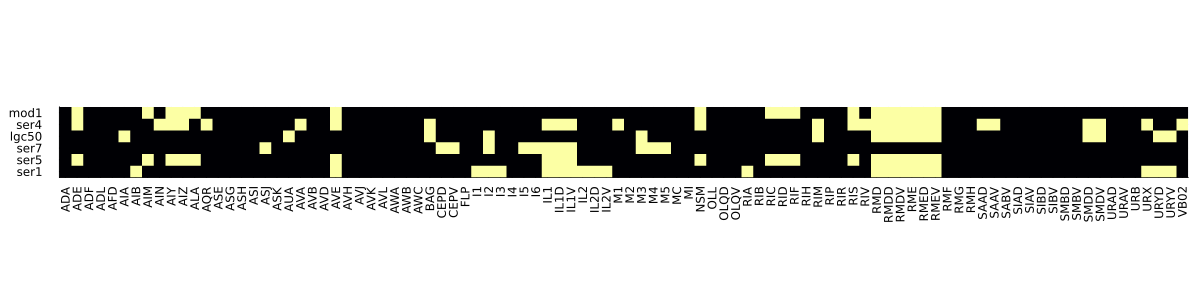

In [552]:
# visualize 5-HTR expression as a heatmap (neurons sorted by alphabetical order)
receptor_expressing_neurons_dv = expression_array_dv[:,1]
array_receptor_expression_dv = Array{Any}(undef, length(receptor_types), length(list_class_any_dv))

for (i, id) = enumerate(list_class_any_dv)
    if id in receptor_expressing_neurons_dv
        idx = findall(x->x==id, receptor_expressing_neurons_dv)
        array_receptor_expression_dv[:,i] = expression_array_dv[idx, 2:end]
    else
        array_receptor_expression_dv[:,i] = [0, 0, 0, 0, 0, 0]
    end
end
heatmap(array_receptor_expression_dv, 
    xticks=(collect(1:length(list_class_any_dv)), list_class_any_dv), xrotation=90, 
    yticks=(collect(1:length(receptor_types)), receptor_types),
    xlims=((0.5, length(list_class_any_dv)+0.5)),
    ylims=((0.5, length(receptor_types)+0.5)),
    aspectratio=1, legend = :none, size=(1200,300))

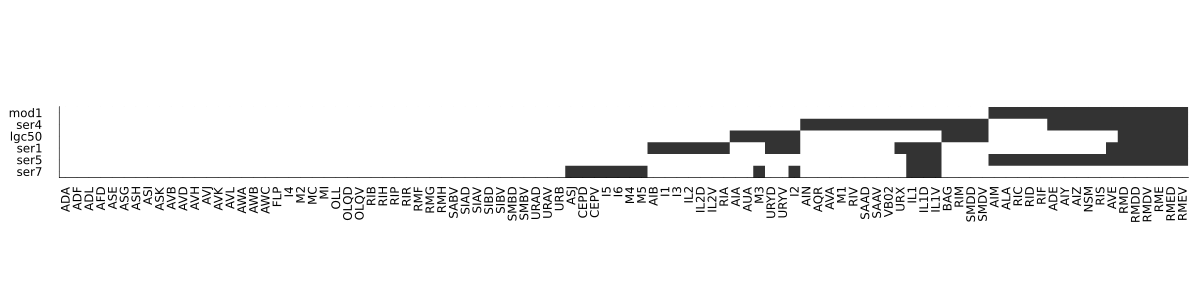

In [553]:
# visualize 5-HTR expression as a clustered heatmap
R = real_kmeans(mat_array_receptor_expression_dv,7)
clust_rank = hcat(1:length(list_class_any_dv), R.assignments, array_receptor_expression_dv')

mat_array_receptor_expression_dv = convert(AbstractMatrix{Int}, array_receptor_expression_dv)
receptor_order = [3,2,1,4,5,6]

for i = receptor_order .+2
    clust_rank = sortslices(clust_rank, dims=1, by = x->x[i])
end
clust_order = clust_rank[:,1];

color_bw = cgrad([:white, :grey20], categorical=true)
heatmap(array_receptor_expression_dv[receptor_order, clust_order], 
    xticks=(collect(1:length(list_class_any_dv)), list_class_any_dv[clust_order]), xrotation=90, 
    yticks=(collect(1:length(receptor_types)), receptor_types[receptor_order]),
    xlims=((0.5, length(list_class_any_dv)+0.5)),
    ylims=((0.5, length(receptor_types)+0.5)), c = color_bw,
    aspectratio=1, legend = :none, size=(1200,300))

## Fraction of observations that a neuron class is correlated to NSM (or its derivative) -- panel A

In [554]:
n_datasets = length(collect(keys(nsm_analysis_dict)));

In [53]:
# load fraction of observations that each neuron is found to have significant correlation with NSM derivative
array_nsm_corr_cat = Array{Any}(undef, 2*n_datasets+1, length(list_class_any_dv)+1)
array_nsm_corr_cat[end, 1:end-1] = list_class_any_dv

array_nsm_corr_cont = Array{Any}(undef, 2*n_datasets+1, length(list_class_any_dv)+1)
array_nsm_corr_cont[end, 1:end-1] = list_class_any_dv

array_notid_cat = Array{Any}(undef, 2*n_datasets+1, length(list_class_any_dv)+1)
array_notid_cat[end, 1:end-1] = list_class_any_dv

array_notid_cont = Array{Any}(undef, 2*n_datasets+1, length(list_class_any_dv)+1)
array_notid_cont[end, 1:end-1] = list_class_any_dv

array_kernel_length = Array{Any}(undef, 2*n_datasets+1, length(list_class_any_dv)+1)
array_kernel_length[end, 1:end-1] = list_class_any_dv
array_kernel_retrospectiveness = Array{Any}(undef, 2*n_datasets+1, length(list_class_any_dv)+1)
array_kernel_retrospectiveness[end, 1:end-1] = list_class_any_dv

# first label for each id
for (i, dataset) = enumerate(sort(collect(keys(nsm_analysis_dict))))
    array_nsm_corr_cat[2*i-1, length(list_class_any_dv)+1] = dataset
    array_nsm_corr_cont[2*i-1, length(list_class_any_dv)+1] = dataset
    array_kernel_length[2*i-1, length(list_class_any_dv)+1] = dataset
    
    orig_dict = nsm_analysis_dict[dataset]["neuron_identity_dv"]
    # reverse_dict = Dict(value => key for (key, value) in orig_dict)
    reverse_dict = invert_dict(orig_dict)
        
    sig_neuron_num = nsm_analysis_dict[dataset]["sig_neuron_num_diff_twice"] ###############################
    
    for (j, id) = enumerate(list_class_any_dv)
        if haskey(reverse_dict, id)
            # found
            array_notid_cat[2*i-1,j] = 0
            array_notid_cont[2*i-1,j] = 0
            neuron_num = reverse_dict[id][1] #########
            if neuron_num in sig_neuron_num
                array_nsm_corr_cat[2*i-1,j] = nsm_analysis_dict[dataset]["nsm_related_class_diff"][neuron_num]
                array_nsm_corr_cont[2*i-1,j] = nsm_analysis_dict[dataset]["nsm_related_class_diff"][neuron_num] + abs(nsm_analysis_dict[dataset]["nsm_corr_coef_diff"][neuron_num])
                array_kernel_length[2*i-1,j] = nsm_analysis_dict[dataset]["nsm_kernel_length_diff"][neuron_num]
            else
                # found but not significant
                array_nsm_corr_cat[2*i-1,j] = 0
                array_nsm_corr_cont[2*i-1,j] = 1
                array_kernel_length[2*i-1,j] = 0.0
            end
        else
            # not found at all
            array_notid_cat[2*i-1,j] = 1
            array_notid_cont[2*i-1,j] = 1
            
            array_nsm_corr_cat[2*i-1,j] = 3
            array_nsm_corr_cont[2*i-1,j] = 3
            
            array_kernel_length[2*i-1,j] = 10.0
        end
    end
end

# second label for each id (if present)
for (i, dataset) = enumerate(sort(collect(keys(nsm_analysis_dict))))
    array_nsm_corr_cat[2*i, length(list_class_any_dv)+1] = dataset
    array_nsm_corr_cont[2*i, length(list_class_any_dv)+1] = dataset
    array_kernel_length[2*i, length(list_class_any_dv)+1] = dataset
    
    orig_dict = nsm_analysis_dict[dataset]["neuron_identity_dv"]
    # reverse_dict = Dict(value => key for (key, value) in orig_dict)
    reverse_dict = invert_dict(orig_dict)
        
    sig_neuron_num = nsm_analysis_dict[dataset]["sig_neuron_num_diff_twice"] ####################################################
    
    for (j, id) = enumerate(list_class_any_dv)
        if haskey(reverse_dict, id)
            array_notid_cat[2*i,j] = 0
            array_notid_cont[2*i,j] = 0
            if length(reverse_dict[id])==2
                neuron_num = reverse_dict[id][2] ######### if the same neuron class has both L and R labelled
            elseif length(reverse_dict[id])==1
                neuron_num = 0
            else
                print("there are more than two neurons labelled $(id) in $(dataset) \n")
                neuron_num = reverse_dict[id][2]
            end
            
            if neuron_num in sig_neuron_num
                array_nsm_corr_cat[2*i,j] = nsm_analysis_dict[dataset]["nsm_related_class_diff"][neuron_num]
                array_nsm_corr_cont[2*i,j] = nsm_analysis_dict[dataset]["nsm_related_class_diff"][neuron_num] + abs(nsm_analysis_dict[dataset]["nsm_corr_coef_diff"][neuron_num])
                array_kernel_length[2*i,j] = nsm_analysis_dict[dataset]["nsm_kernel_length_diff"][neuron_num]          
            else
                array_nsm_corr_cat[2*i,j] = 0 # insignificant
                array_nsm_corr_cont[2*i,j] = 1 # insignificant
                
                array_kernel_length[2*i,j] = 0.0
            end
        else
            array_notid_cat[2*i,j] = 1
            array_notid_cont[2*i,j] = 1
            
            array_nsm_corr_cat[2*i,j] = 3 # no info
            array_nsm_corr_cont[2*i,j] = 3 # no info
            
            array_kernel_length[2*i,j] = 10.0
        end
    end
    print(dataset, "\n")
end

total_obs_diff = zeros(size(array_nsm_corr_cat,2)-1)
total_pos_diff = zeros(size(array_nsm_corr_cat,2)-1)
total_neg_diff = zeros(size(array_nsm_corr_cat,2)-1)

for i = 1:size(array_nsm_corr_cat,2)-1
    total_obs_diff[i] = length(findall(x->x in [0,1,2], array_nsm_corr_cat[:,i]))
    total_pos_diff[i] = length(findall(x->x == 1, array_nsm_corr_cat[:,i]))
    total_neg_diff[i] = length(findall(x->x == 2, array_nsm_corr_cat[:,i]))
end

2022-07-26-31
2022-07-26-38
2022-07-27-31
2022-07-27-45
2022-08-02-38
2022-08-03-31


In [1057]:
# load fraction of observations that each neuron is found to have significant correlation with NSM itself
array_nsm_corr_cat = Array{Any}(undef, 2*n_datasets+1, length(list_class_any_dv)+1)
array_nsm_corr_cat[end, 1:end-1] = list_class_any_dv

array_nsm_corr_cont = Array{Any}(undef, 2*n_datasets+1, length(list_class_any_dv)+1)
array_nsm_corr_cont[end, 1:end-1] = list_class_any_dv

array_notid_cat = Array{Any}(undef, 2*n_datasets+1, length(list_class_any_dv)+1)
array_notid_cat[end, 1:end-1] = list_class_any_dv

array_notid_cont = Array{Any}(undef, 2*n_datasets+1, length(list_class_any_dv)+1)
array_notid_cont[end, 1:end-1] = list_class_any_dv

array_kernel_length = Array{Any}(undef, 2*n_datasets+1, length(list_class_any_dv)+1)
array_kernel_length[end, 1:end-1] = list_class_any_dv
array_kernel_retrospectiveness = Array{Any}(undef, 2*n_datasets+1, length(list_class_any_dv)+1)
array_kernel_retrospectiveness[end, 1:end-1] = list_class_any_dv

array_nsm_corr_coef = Array{Any}(undef, 2*n_datasets, length(list_class_any_dv))

# first label for each id
for (i, dataset) = enumerate(sort(collect(keys(nsm_analysis_dict))))
    array_nsm_corr_cat[2*i-1, length(list_class_any_dv)+1] = dataset
    array_nsm_corr_cont[2*i-1, length(list_class_any_dv)+1] = dataset
    array_kernel_length[2*i-1, length(list_class_any_dv)+1] = dataset
    array_kernel_retrospectiveness[2*i-1, length(list_class_any_dv)+1] = dataset
    
    orig_dict = nsm_analysis_dict[dataset]["neuron_identity_dv"]
    # reverse_dict = Dict(value => key for (key, value) in orig_dict)
    reverse_dict = invert_dict(orig_dict)
        
    sig_neuron_num = nsm_analysis_dict[dataset]["sig_neuron_num_twice"] ###############################
    
    for (j, id) = enumerate(list_class_any_dv)
        if haskey(reverse_dict, id)
            # found
            array_notid_cat[2*i-1,j] = 0
            array_notid_cont[2*i-1,j] = 0
            neuron_num = reverse_dict[id][1] #########
            array_nsm_corr_coef[2*i-1,j] = nsm_analysis_dict[dataset]["nsm_corr_coef"][neuron_num]
            
            if neuron_num in sig_neuron_num
                array_nsm_corr_cat[2*i-1,j] = nsm_analysis_dict[dataset]["nsm_related_class"][neuron_num]
                array_nsm_corr_cont[2*i-1,j] = nsm_analysis_dict[dataset]["nsm_related_class"][neuron_num] + abs(nsm_analysis_dict[dataset]["nsm_corr_coef"][neuron_num])
                array_kernel_length[2*i-1,j] = nsm_analysis_dict[dataset]["nsm_kernel_length"][neuron_num]
                array_kernel_retrospectiveness[2*i-1,j] = nsm_analysis_dict[dataset]["nsm_kernel_retrospectiveness"][neuron_num]
            else
                # found but not significant
                array_nsm_corr_cat[2*i-1,j] = 0
                array_nsm_corr_cont[2*i-1,j] = 1
                array_kernel_length[2*i-1,j] = 0.0
                array_kernel_retrospectiveness[2*i-1,j] = 0
            end
        else
            # not found at all
            array_notid_cat[2*i-1,j] = 1
            array_notid_cont[2*i-1,j] = 1
            
            array_nsm_corr_cat[2*i-1,j] = 3
            array_nsm_corr_cont[2*i-1,j] = 3
            
            array_kernel_length[2*i-1,j] = 10.0
            array_kernel_retrospectiveness[2*i-1,j] = 17
            
            array_nsm_corr_coef[2*i-1,j] = NaN
        end
    end
end

# second label for each id (if present)
for (i, dataset) = enumerate(sort(collect(keys(nsm_analysis_dict))))
    array_nsm_corr_cat[2*i, length(list_class_any_dv)+1] = dataset
    array_nsm_corr_cont[2*i, length(list_class_any_dv)+1] = dataset
    array_kernel_length[2*i, length(list_class_any_dv)+1] = dataset
    array_kernel_retrospectiveness[2*i, length(list_class_any_dv)+1] = dataset
    
    orig_dict = nsm_analysis_dict[dataset]["neuron_identity_dv"]
    # reverse_dict = Dict(value => key for (key, value) in orig_dict)
    reverse_dict = invert_dict(orig_dict)
        
    sig_neuron_num = nsm_analysis_dict[dataset]["sig_neuron_num_twice"] ####################################################
    
    for (j, id) = enumerate(list_class_any_dv)
        if haskey(reverse_dict, id)
            array_notid_cat[2*i,j] = 0
            array_notid_cont[2*i,j] = 0
            if length(reverse_dict[id])==2
                neuron_num = reverse_dict[id][2] ######### if the same neuron class has both L and R labelled
                array_nsm_corr_coef[2*i,j] = nsm_analysis_dict[dataset]["nsm_corr_coef"][neuron_num]
            elseif length(reverse_dict[id])==1
                neuron_num = 0
                array_nsm_corr_coef[2*i,j] = NaN
            else
                print("there are more than two neurons labelled $(id) in $(dataset) \n")
                neuron_num = reverse_dict[id][2]
                array_nsm_corr_coef[2*i,j] = nsm_analysis_dict[dataset]["nsm_corr_coef"][neuron_num]
            end
            
            
            if neuron_num in sig_neuron_num
                array_nsm_corr_cat[2*i,j] = nsm_analysis_dict[dataset]["nsm_related_class"][neuron_num]
                array_nsm_corr_cont[2*i,j] = nsm_analysis_dict[dataset]["nsm_related_class"][neuron_num] + abs(nsm_analysis_dict[dataset]["nsm_corr_coef"][neuron_num])
                array_kernel_length[2*i,j] = nsm_analysis_dict[dataset]["nsm_kernel_length"][neuron_num]
                array_kernel_retrospectiveness[2*i,j] = nsm_analysis_dict[dataset]["nsm_kernel_retrospectiveness"][neuron_num]            
            else
                array_nsm_corr_cat[2*i,j] = 0
                array_nsm_corr_cont[2*i,j] = 1
                
                array_kernel_length[2*i,j] = 0.0
                array_kernel_retrospectiveness[2*i,j] = 0
            end
        else
            array_notid_cat[2*i,j] = 1
            array_notid_cont[2*i,j] = 1
            
            array_nsm_corr_cat[2*i,j] = 3
            array_nsm_corr_cont[2*i,j] = 3
            
            array_kernel_length[2*i,j] = 10.0
            array_kernel_retrospectiveness[2*i,j] = 17
            
            array_nsm_corr_coef[2*i,j] = NaN
        end
    end
    print(dataset, "\n")
end

total_obs = zeros(size(array_nsm_corr_cat,2)-1)
total_pos = zeros(size(array_nsm_corr_cat,2)-1)
total_neg = zeros(size(array_nsm_corr_cat,2)-1)

for i = 1:size(array_nsm_corr_cat,2)-1
    total_obs[i] = length(findall(x->x in [0,1,2], array_nsm_corr_cat[:,i]))
    total_pos[i] = length(findall(x->x == 1, array_nsm_corr_cat[:,i]))
    total_neg[i] = length(findall(x->x == 2, array_nsm_corr_cat[:,i]))
end

2022-07-26-31
2022-07-26-38
2022-07-27-31
2022-07-27-45
2022-08-02-38
2022-08-03-31


In [447]:
# categorize each neuron class as pharyngeal, sensory, inter and/or motor
list_neuron_category = []
for neuron = list_class_any_dv
    if neuron_location_dict[neuron] == "pharynx"
        c = 0
    elseif neuron in sensory_neuron_id
        c = 1
    elseif neuron in inter_neuron_id
        c = 2
    elseif neuron in motor_neuron_id
        c = 3
    end
    push!(list_neuron_category, c)
end

mat_type = zeros(length(list_class_any_dv), 4)
n = 1
for neuron = list_class_any_dv
    if neuron_location_dict[neuron] == "pharynx"
        mat_type[n,1] = 1
    end
    if neuron in sensory_neuron_id
        mat_type[n,2] = 1
    end
    if neuron in inter_neuron_id
        mat_type[n,3] = 1
    end
    if neuron in motor_neuron_id
        mat_type[n,4] = 1
    end
    n = n+1
end

Mat = hcat(list_neuron_category,
        total_pos ./total_obs,
        total_neg ./ total_obs,
        zeros(size(list_neuron_category)),
        total_pos_diff ./total_obs_diff,
        total_neg_diff ./ total_obs_diff,
        zeros(size(list_neuron_category)))

96×7 Matrix{Any}:
 2    0.0          0.125      0.0    0.0          0.0  0.0
 1    0.0          0.1        0.0    0.0          0.0  0.0
 1  NaN          NaN          0.0  NaN          NaN    0.0
 1    0.0          0.0        0.0    0.0          0.0  0.0
 1  NaN          NaN          0.0  NaN          NaN    0.0
 2    0.0          0.0        0.0    0.0          0.0  0.0
 2    0.0          0.5        0.0    0.0          0.0  0.0
 2    0.0          0.375      0.0    0.0          0.0  0.0
 2    0.166667     0.0        0.0    0.0833333    0.0  0.0
 2    0.25         0.0        0.0    0.0          0.0  0.0
 2    0.0          0.25       0.0    0.0          0.0  0.0
 2    0.0          0.0        0.0    0.0          0.0  0.0
 1    0.0          0.0        0.0    0.0          0.0  0.0
 ⋮                                                ⋮    
 3    0.0          0.0        0.0    0.0          0.0  0.0
 2    0.0          0.0        0.0    0.0          0.0  0.0
 2    0.0          0.5        0.0    0.0 

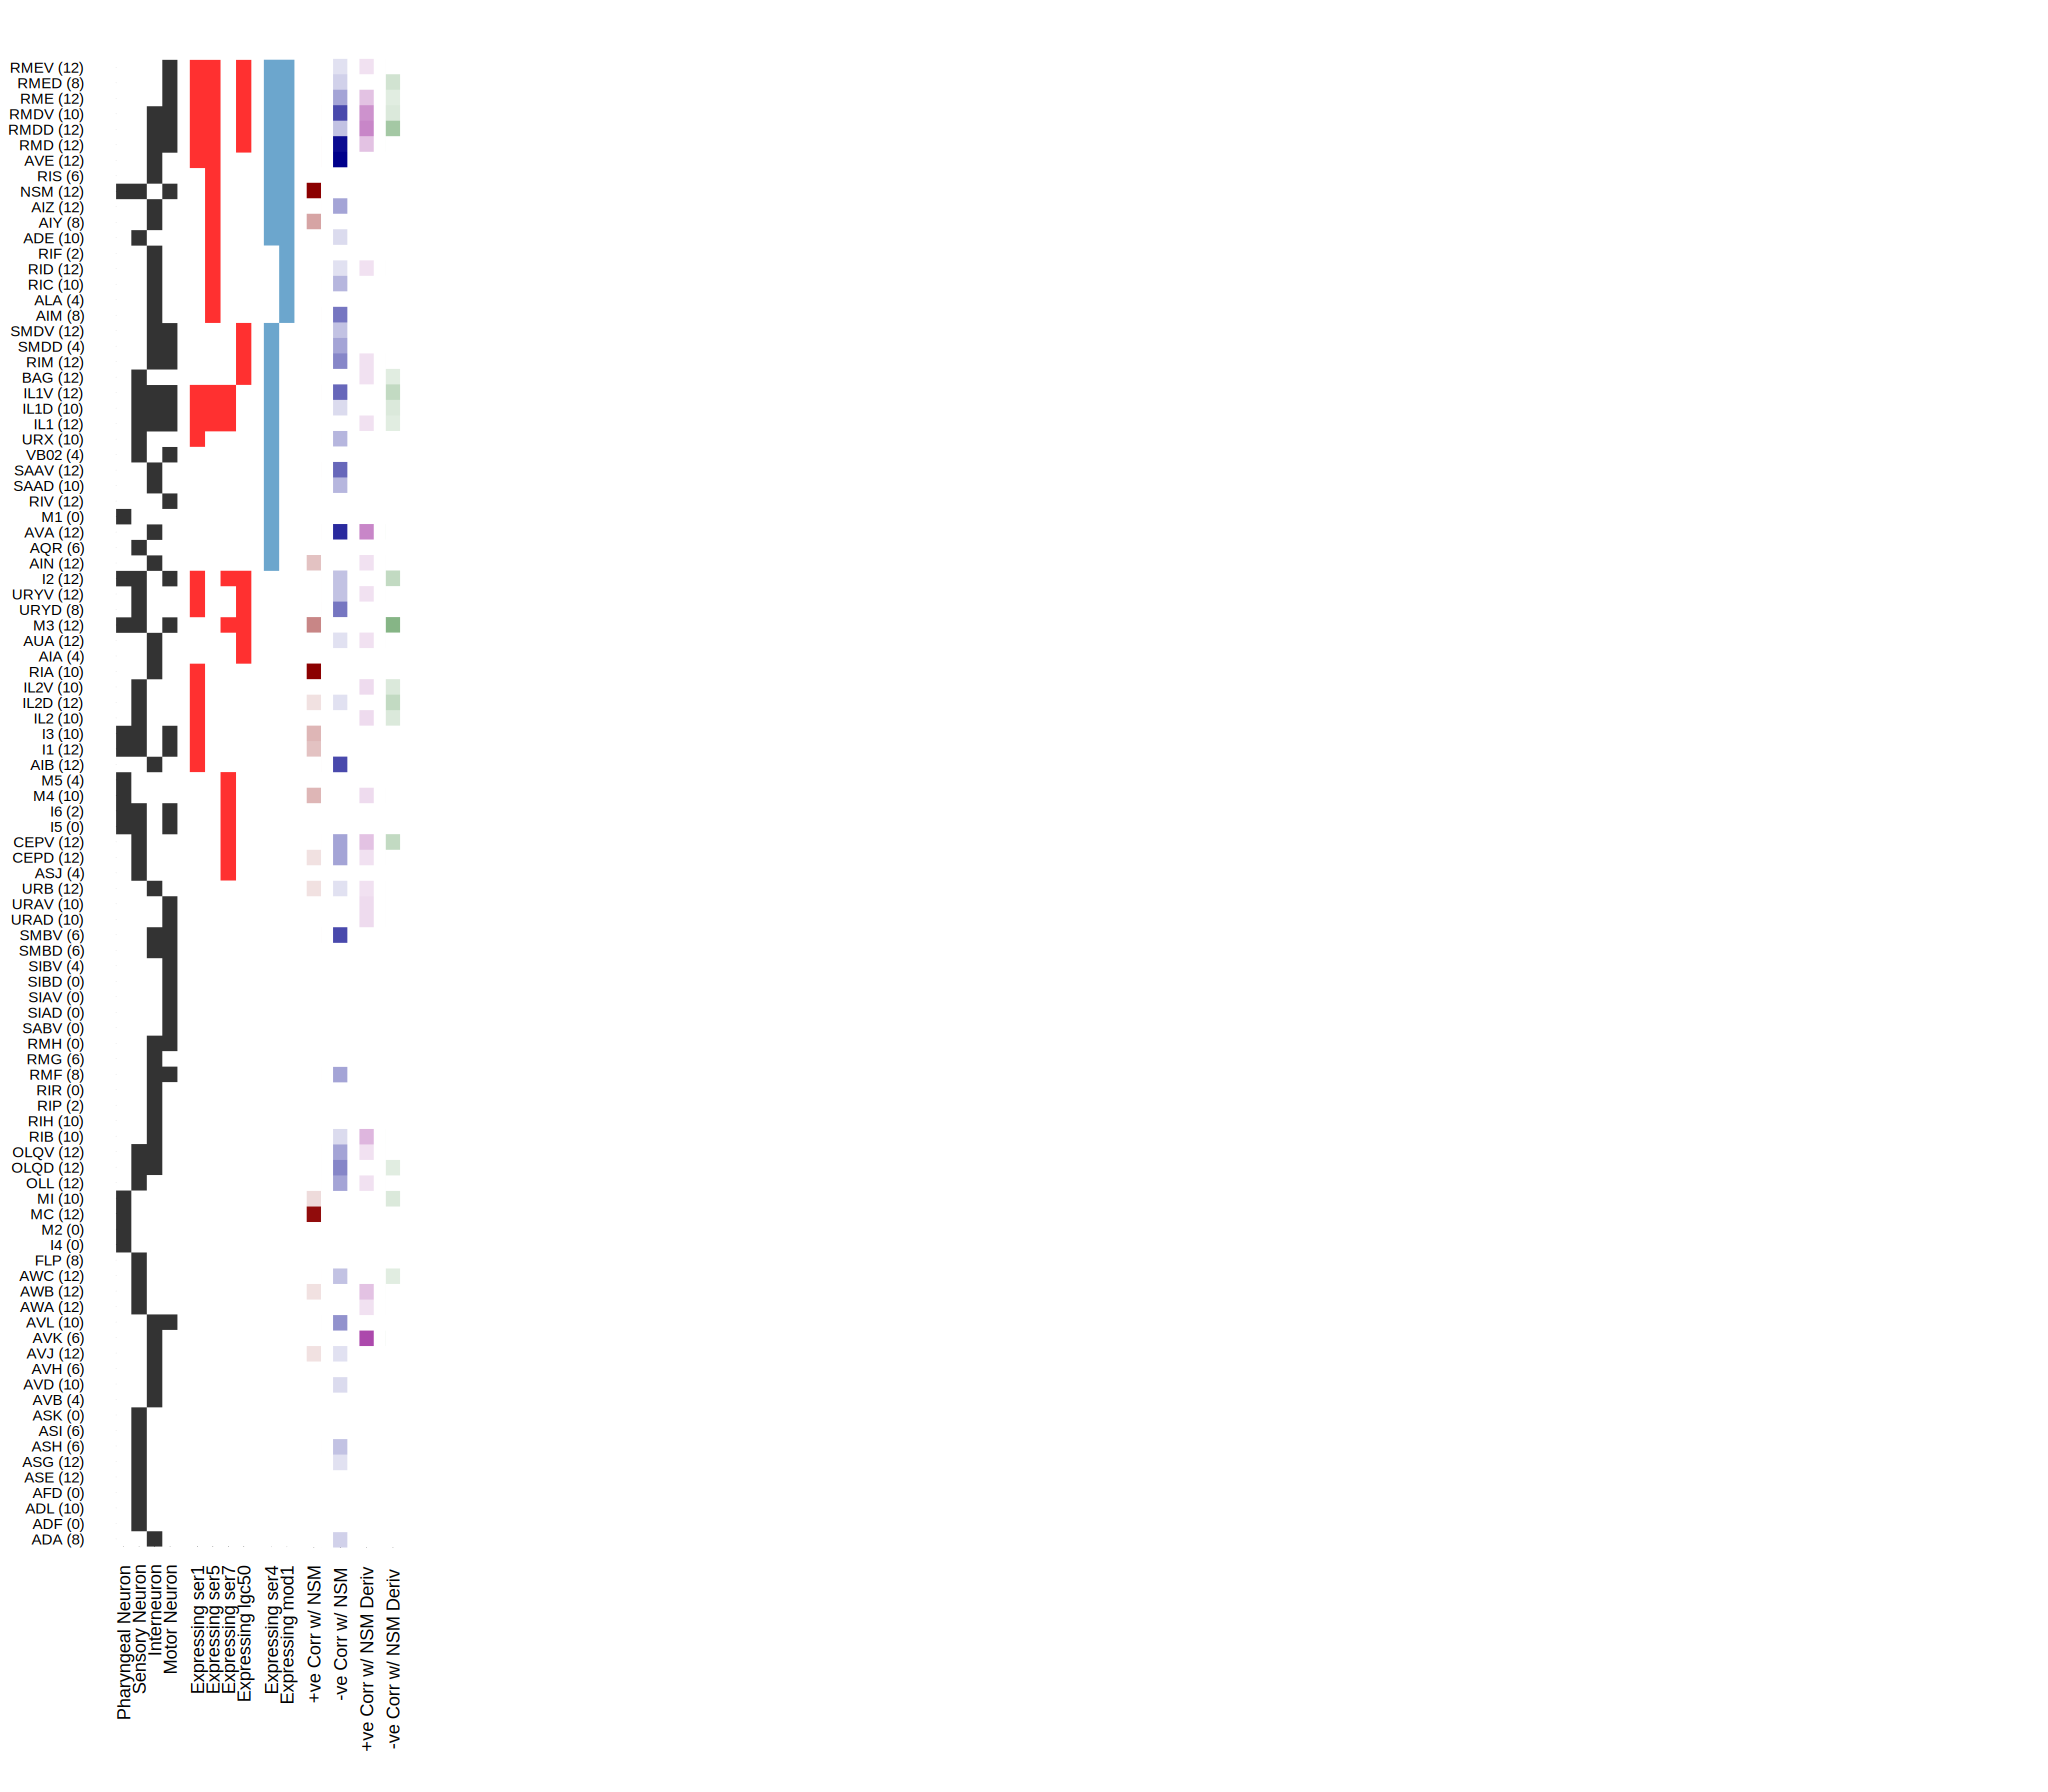

In [1295]:
l = @layout [Plots.grid(1,7, widths=[0.0331, 0.03343, 0.01672, 0.0077, 0.0077, 0.0077, 0.0077])]
yaxis = false

color_red = cgrad([:white, :red4], scale=:exp)
color_blue = cgrad([:white, :blue4])
color_violet = cgrad([:white, :magenta4])
color_green = cgrad([:white, :darkgreen])
color_gold = cgrad([:white, :coral3, :gold, :black], [0,0.00001, 0.0001,0.5,0.99, 0.9999,1])
color_red_lite = cgrad([:white, :firebrick1], categorical=true)
color_blue_lite = cgrad([:white, :skyblue3], categorical=true);

p1 = heatmap(mat_type[clust_order,:], 
    yticks = (1:length(list_class_any_dv), list_class_any_dv[clust_order].*" (".*string.(Int.(total_obs[clust_order])).*")"), ytickfontsize=20, ylabel = "neurons",
    xticks=([1,2,3,4], ["Pharyngeal Neuron", "Sensory Neuron", "Interneuron", "Motor Neuron"]), xtickfontsize=24, xlims=(0.52, 4.48), ylims=((0.5, length(list_class_any_dv)+0.5)),
    xrotation = 90, color=color_bw, aspect_ratio=1, clim=(0,1), colorbar=false; yflip=false)

p2 = heatmap(Mat[clust_order,2:3], 
    yticks = [], 
    xticks=([1], ["+ve Corr w/ NSM"]), xtickfontsize=24, xlims=(0.54,1.46), ylims=((0.5, length(list_class_any_dv)+0.5)),
    xrotation = 90, color=color_red, aspect_ratio=1, clim=(0, 0.7), colorbar=false, yaxis=false; yflip=false)

p3 = heatmap(Mat[clust_order,2:3], yticks = [],
    xticks=([2], ["-ve Corr w/ NSM"]), xtickfontsize=24, xlims=(1.54,2.46), ylims=((0.5, length(list_class_any_dv)+0.5)),
    xrotation = 90, color=color_blue, aspect_ratio=1, clim=(0, 0.7), colorbar=false, yaxis=false; yflip=false)

p5 = heatmap(Mat[clust_order,5:6], yticks=[],
    xticks=([1], ["+ve Corr w/ NSM Deriv"]), xtickfontsize=24, xlims=(0.54,1.46), ylims=((0.5, length(list_class_any_dv)+0.5)),
    xrotation = 90, color=color_violet, aspect_ratio=1, clim=(0,0.7), colorbar=false, yaxis=yaxis; yflip=false)

p6 = heatmap(Mat[clust_order,5:6], yticks=[],
    xticks=([2], ["-ve Corr w/ NSM Deriv"]), xtickfontsize=24, xlims=(1.54,2.46), ylims=((0.5, length(list_class_any_dv)+0.5)),
    xrotation = 90, color=color_green, aspect_ratio=1, clim=(0,0.7), colorbar=false, yaxis=yaxis; yflip=false)

p8 = heatmap(permutedims(array_receptor_expression_dv[sort(receptor_order)[1:4], clust_order]), yticks=[],
    xrotation = 90, xticks=([1,2,3,4], "Expressing ".*receptor_types[1:4]), xtickfontsize=24, 
    ylims=((0.5, length(list_class_any_dv)+0.5)),
    c = color_red_lite,
    aspectratio=1, legend = :none)

p9 = heatmap(permutedims(array_receptor_expression_dv[sort(receptor_order)[5:6], clust_order]), yticks=[],
    xrotation = 90, xticks=([1,2], "Expressing ".*receptor_types[5:6]), xtickfontsize=24, 
    ylims=((0.5, length(list_class_any_dv)+0.5)),
    c = color_blue_lite,
    aspectratio=1, legend = :none)

Plots.plot(p1, p8, p9, p2, p3, p5, p6, layout=l, show=true, size=(4000,3500), foreground_color_border=:white, xmirror=false, grid=:off, fontfamily="arial")

In [557]:
# exclude NSM itself from the rest of the analysis and visualization
nsm_idx_list = findall(x->x=="NSM", list_class_any_dv)[1]
no_nsm_list = vcat(1:nsm_idx_list-1,nsm_idx_list+1:length(list_class_any_dv));

In [558]:
clust_nsm_idx = findall(x->x=="NSM", list_class_any_dv[clust_order])[1]
clust_no_nsm_list = setdiff(1:length(list_class_any_dv), clust_nsm_idx);

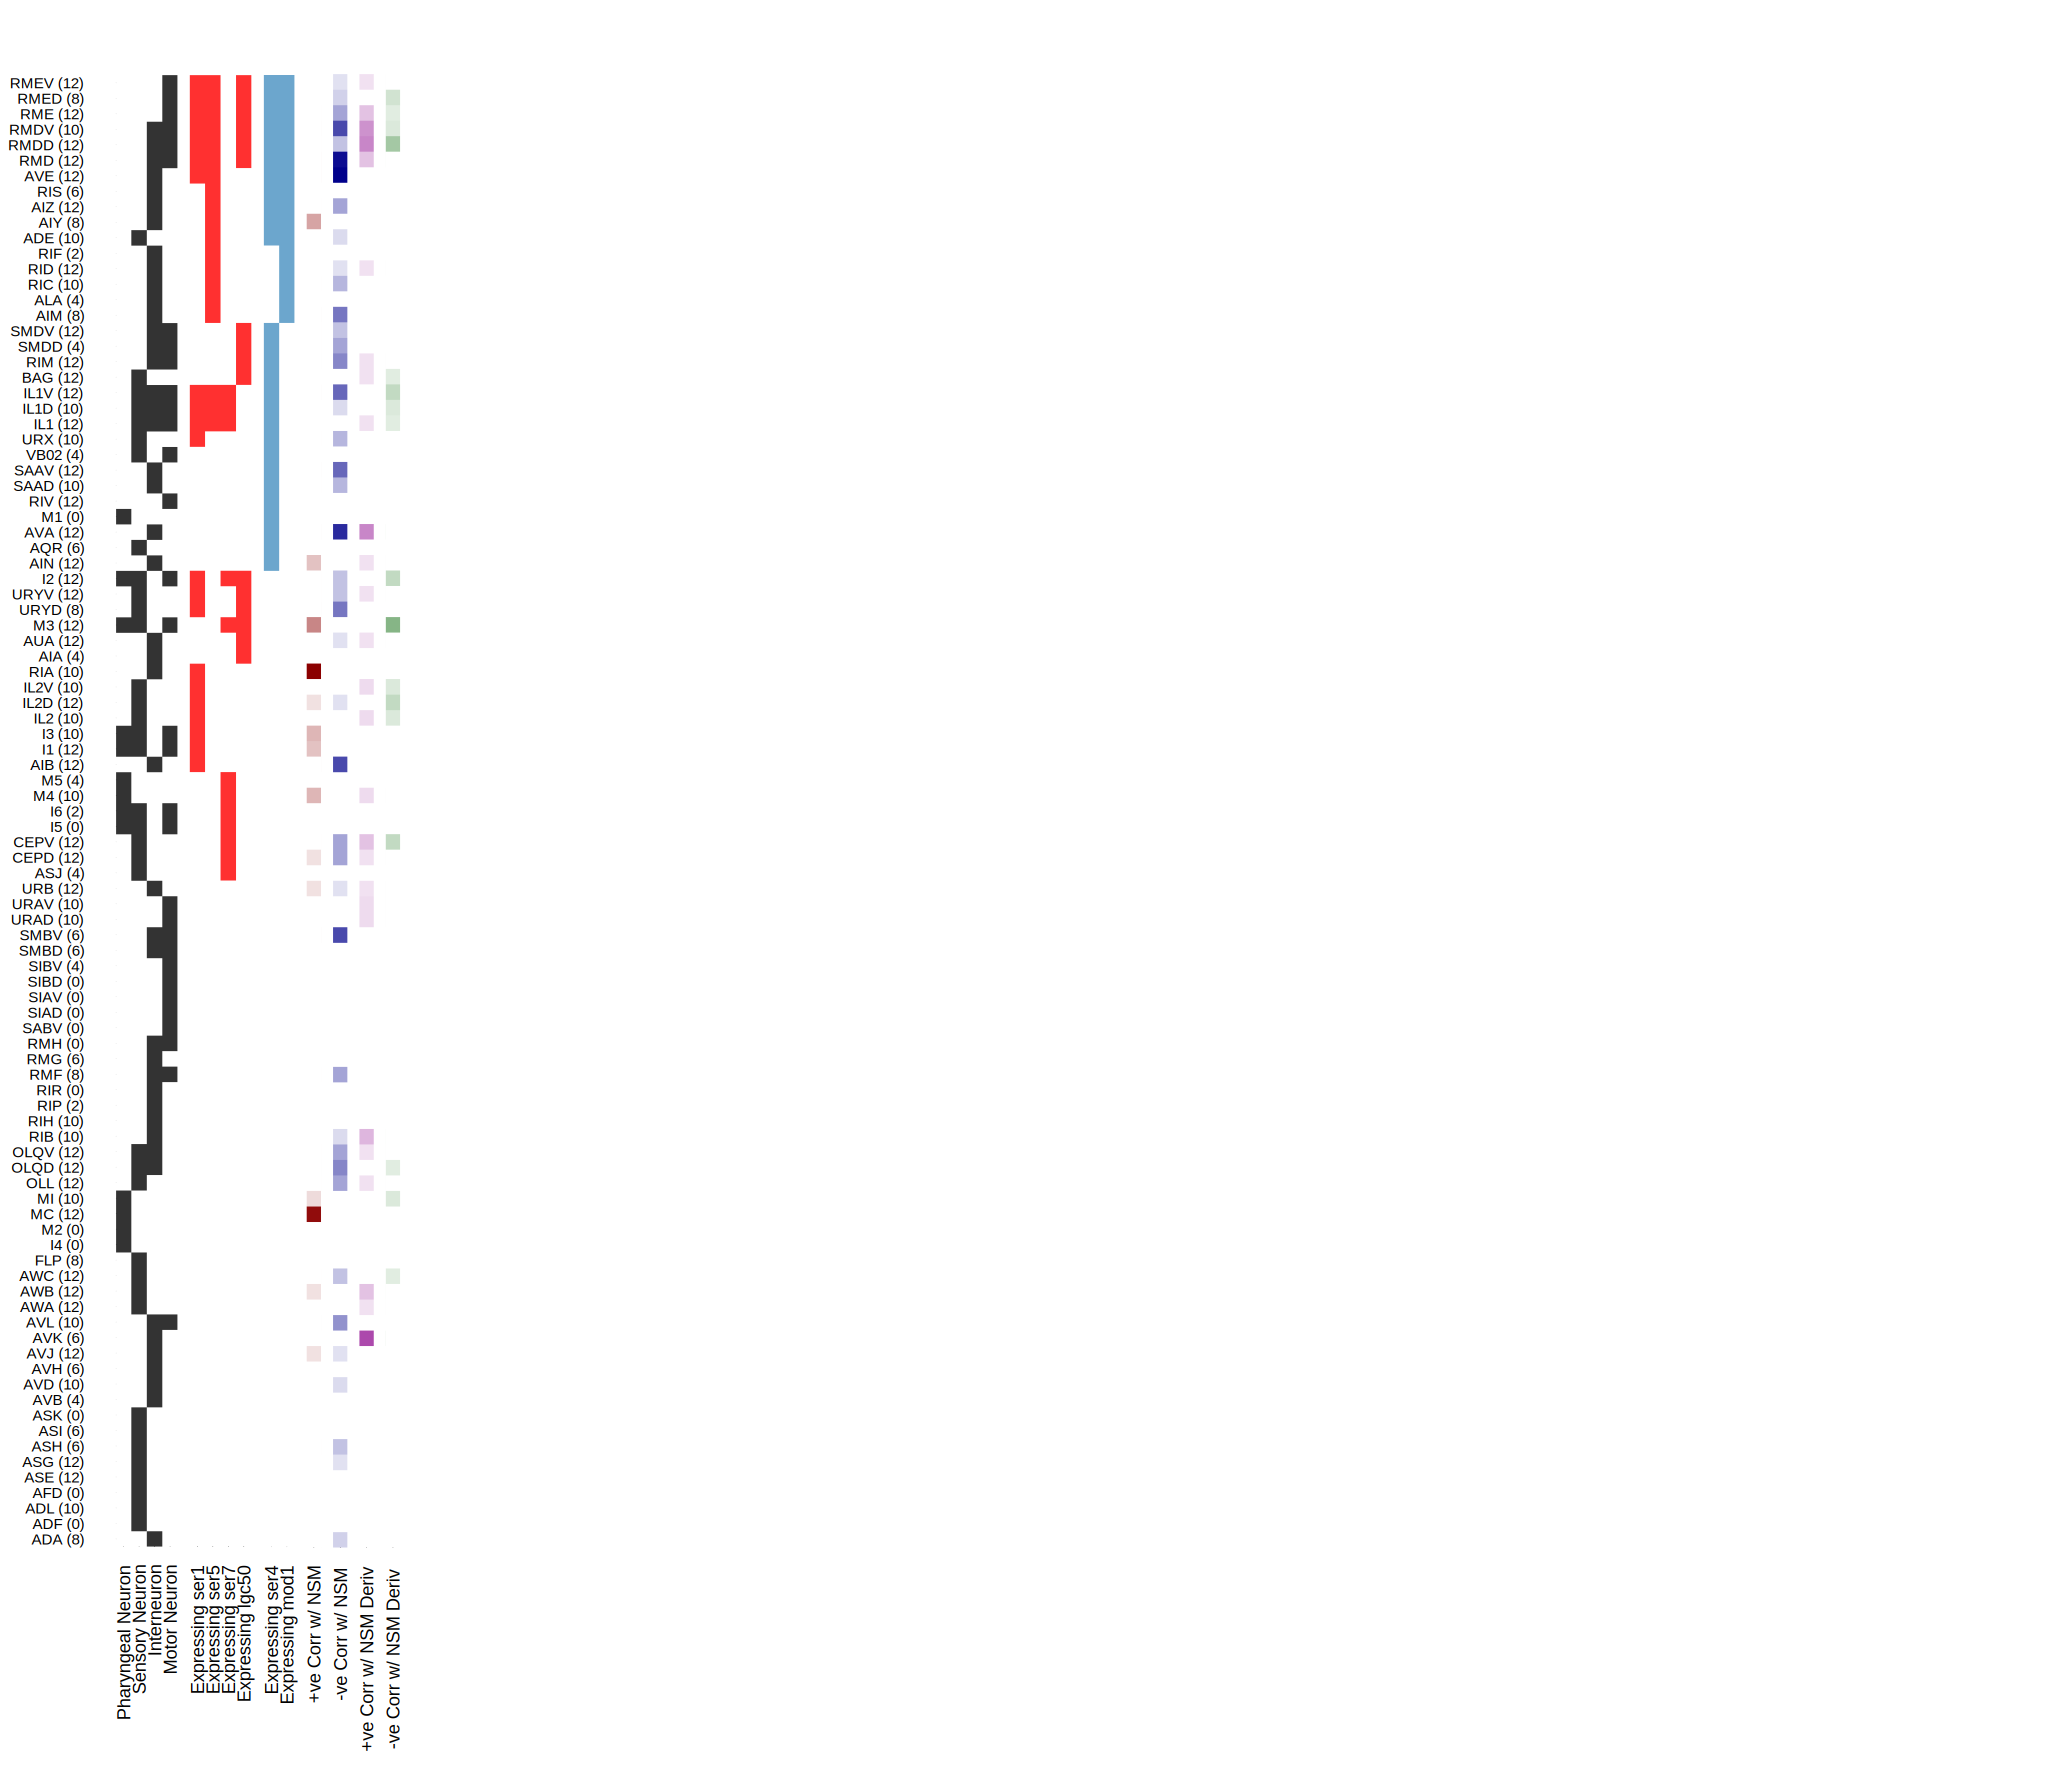

In [1293]:
l = @layout [Plots.grid(1,7, widths=[0.0331, 0.03343, 0.01672, 0.0077, 0.0077, 0.0077, 0.0077])]
yaxis = false

color_red = cgrad([:white, :red4], scale=:exp)
color_blue = cgrad([:white, :blue4])
color_violet = cgrad([:white, :magenta4])
color_green = cgrad([:white, :darkgreen])
color_gold = cgrad([:white, :coral3, :gold, :black], [0,0.00001, 0.0001,0.5,0.99, 0.9999,1])
color_red_lite = cgrad([:white, :firebrick1], categorical=true)
color_blue_lite = cgrad([:white, :skyblue3], categorical=true);

p1 = heatmap(mat_type[clust_order,:][clust_no_nsm_list,:], 
    yticks = (1:length(clust_no_nsm_list), list_class_any_dv[clust_order][clust_no_nsm_list].*" (".*string.(Int.(total_obs[clust_order][clust_no_nsm_list])).*")"), ytickfontsize=20, ylabel = "neurons",
    xticks=([1,2,3,4], ["Pharyngeal Neuron", "Sensory Neuron", "Interneuron", "Motor Neuron"]), xtickfontsize=24, xlims=(0.52, 4.48), ylims=((0.5, length(list_class_any_dv)+0.5)),
    xrotation = 90, color=color_bw, aspect_ratio=1, clim=(0,1), colorbar=false; yflip=false)

p2 = heatmap(Mat[clust_order,2:3][clust_no_nsm_list,:], 
    yticks = [], 
    xticks=([1], ["+ve Corr w/ NSM"]), xtickfontsize=24, xlims=(0.54,1.46), ylims=((0.5, length(list_class_any_dv)+0.5)),
    xrotation = 90, color=color_red, aspect_ratio=1, clim=(0, 0.7), colorbar=false, yaxis=false; yflip=false)

p3 = heatmap(Mat[clust_order,2:3][clust_no_nsm_list,:], yticks = [],
    xticks=([2], ["-ve Corr w/ NSM"]), xtickfontsize=24, xlims=(1.54,2.46), ylims=((0.5, length(list_class_any_dv)+0.5)),
    xrotation = 90, color=color_blue, aspect_ratio=1, clim=(0, 0.7), colorbar=false, yaxis=false; yflip=false)

p5 = heatmap(Mat[clust_order,5:6][clust_no_nsm_list,:], yticks=[],
    xticks=([1], ["+ve Corr w/ NSM Deriv"]), xtickfontsize=24, xlims=(0.54,1.46), ylims=((0.5, length(list_class_any_dv)+0.5)),
    xrotation = 90, color=color_violet, aspect_ratio=1, clim=(0,0.7), colorbar=false, yaxis=yaxis; yflip=false)

p6 = heatmap(Mat[clust_order,5:6][clust_no_nsm_list,:], yticks=[],
    xticks=([2], ["-ve Corr w/ NSM Deriv"]), xtickfontsize=24, xlims=(1.54,2.46), ylims=((0.5, length(list_class_any_dv)+0.5)),
    xrotation = 90, color=color_green, aspect_ratio=1, clim=(0,0.7), colorbar=false, yaxis=yaxis; yflip=false)

p8 = heatmap(permutedims(array_receptor_expression_dv[sort(receptor_order)[1:4], clust_order][:,clust_no_nsm_list]), yticks=[],
    xrotation = 90, xticks=([1,2,3,4], "Expressing ".*receptor_types[1:4]), xtickfontsize=24, 
    ylims=((0.5, length(list_class_any_dv)+0.5)),
    c = color_red_lite,
    aspectratio=1, legend = :none)

p9 = heatmap(permutedims(array_receptor_expression_dv[sort(receptor_order)[5:6], clust_order][:,clust_no_nsm_list]), yticks=[],
    xrotation = 90, xticks=([1,2], "Expressing ".*receptor_types[5:6]), xtickfontsize=24, 
    ylims=((0.5, length(list_class_any_dv)+0.5)),
    c = color_blue_lite,
    aspectratio=1, legend = :none)

Plots.plot(p1, p8, p9, p2, p3, p5, p6, layout=l, show=true, size=(4000,3500), foreground_color_border=:white, xmirror=false, grid=:off, fontfamily="arial")

## Supp Figure 7

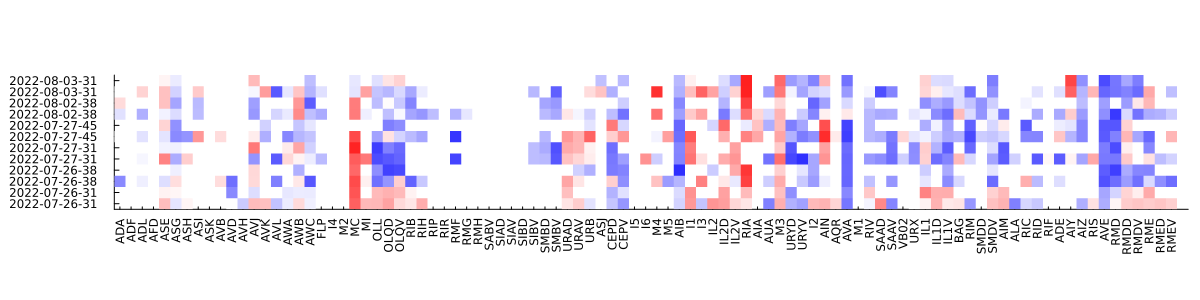

In [561]:
color_BuRd = cgrad([:blue, :white, :red])    

Plots.plot()
heatmap(array_nsm_corr_coef[1:2*n_datasets, clust_order][:,clust_no_nsm_list], 
    xticks=(collect(1:length(list_class_any_dv)-1), list_class_any_dv[clust_order][clust_no_nsm_list]), xrotation=90, 
    yticks=(collect(1:2*n_datasets), array_nsm_corr_cont[1:size(array_nsm_corr_cont,1)-1, size(array_nsm_corr_cont,2)]),
    xlims=((0.5, length(list_class_any_dv)+0.5)),
    ylims=((0.5, 2*n_datasets+0.5)),
    c = color_BuRd, clims = (-1,1), grid=:off,
    aspectratio=1, legend = :none, size=(1200,300), background_color=:white)

## Identify neuron classes that are correlated to NSM

In [457]:
# rows are observations, columns are neuron classes ranked according to list_class_any_dv
# 1 = positive correlation with NSM; 2 = negative correlation with NSM; 3 = 
cat_matrix = array_nsm_corr_cat[1:2*n_datasets, :]

12×97 Matrix{Any}:
 3  3  3  3  3  3  0  0  0  3  0  0  0  …  0  0  0  0  0  3  "2022-07-26-31"
 3  3  3  3  3  3  0  0  0  3  0  0  0     0  0  0  0  0  3  "2022-07-26-31"
 2  0  3  0  3  3  0  3  0  3  0  3  3     0  0  3  3  0  3  "2022-07-26-38"
 0  0  3  0  3  3  2  3  0  3  0  3  3     0  2  3  3  0  3  "2022-07-26-38"
 3  2  3  0  3  3  2  2  0  0  0  0  3     0  0  2  2  2  0  "2022-07-27-31"
 3  0  3  0  3  3  2  2  0  0  0  0  3  …  0  0  2  2  0  0  "2022-07-27-31"
 0  0  3  0  3  0  2  0  1  0  2  3  0     0  1  0  0  2  0  "2022-07-27-45"
 0  0  3  0  3  0  2  0  1  0  2  3  0     0  0  0  2  0  0  "2022-07-27-45"
 0  0  3  0  3  0  0  2  0  0  0  3  3     0  0  0  3  0  3  "2022-08-02-38"
 0  0  3  0  3  0  2  0  0  0  0  3  3     0  0  0  3  0  3  "2022-08-02-38"
 0  0  3  0  3  3  0  3  0  1  0  3  0  …  3  0  0  0  0  3  "2022-08-03-31"
 0  0  3  0  3  3  0  3  0  1  2  3  0     3  0  0  0  0  3  "2022-08-03-31"

In [562]:
# rows are receptors, columns are neuron classes ranked according to list_class_any_dv
# 1 = receptor expressed ; 0 = receptor not expressed
exp_matrix = array_receptor_expression_dv[receptor_order, :]

6×96 Matrix{Any}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  1  0  1  1  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  1  1  1  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  1  1  0  0  0  0  1  1  0
 0  1  0  0  0  0  0  0  1  1  1  0  1     0  0  0  1  1  0  0  0  1  0  0  1
 0  1  0  0  0  0  0  1  0  1  1  1  0  …  0  0  0  0  0  0  0  0  0  0  0  0

In [1366]:
fdr_thresh = 0.1 # set false detection rate threshold; same conclusion whether you set it to 0.1 or 0.15

list_class_any_dv_obs = list_class_any_dv[findall(x->x .>0, total_obs)] # identify neurons that are identified at least once
exp_matrix_obs = exp_matrix[:,findall(x->x .>0, total_obs)]
cat_matrix_obs = cat_matrix[:,findall(x->x .>0, total_obs)]

binary_modulated_obs = zeros(length(list_class_any_dv_obs)) # is this neuron class associated with NSM for at least fdr_thresh of the observations?

for col = 1:length(list_class_any_dv_obs)
    if length(findall(x->x==1 || x==2, cat_matrix_obs[:, col])) > total_obs[col]*fdr_thresh
        binary_modulated_obs[col] = 1
    end
end

In [1367]:
# find neurons that are correlated to NSM for more than $(fdr_thresh) of the time, and those that are not so
modulated_neuron_id = list_class_any_dv_obs[findall(x->x==1, binary_modulated_obs)]
not_modulated_neuron_id = list_class_any_dv_obs[findall(x->x==0, binary_modulated_obs)];

In [1368]:
# ignore the fact that NSM correlates to itself in the statistical analysis
modulated_neuron_id = filter(x->x != "NSM", modulated_neuron_id)
println(modulated_neuron_id)

["ADA", "AIB", "AIM", "AIN", "AIY", "AIZ", "ASG", "AUA", "AVA", "AVE", "AVJ", "AVL", "AWB", "AWC", "CEPD", "CEPV", "I1", "I2", "I3", "IL1V", "IL2D", "M3", "M4", "MC", "OLL", "OLQD", "OLQV", "RIA", "RIC", "RIM", "RMD", "RMDD", "RMDV", "RME", "RMED", "RMEV", "RMF", "SAAD", "SAAV", "SMBV", "SMDV", "URB", "URX", "URYD", "URYV"]


In [1369]:
println(not_modulated_neuron_id)

["ADE", "ADL", "AIA", "ALA", "AQR", "ASE", "ASH", "ASI", "ASJ", "AVB", "AVD", "AVH", "AVK", "AWA", "BAG", "FLP", "I6", "IL1", "IL1D", "IL2", "IL2V", "M5", "MI", "RIB", "RID", "RIF", "RIH", "RIP", "RIS", "RIV", "RMG", "SIBV", "SMBD", "SMDD", "URAD", "URAV", "VB02"]


## Evaluate NSM correlation across neuron categories -- panel B

In [1370]:
nanmean(x) = mean(filter(!isnan,x))
nanmean(x,y) = mapslices(nanmean,x,dims=y)
list_nsm_corrcoef_raw = nanmean(1 .*array_nsm_corr_coef,1)

1×96 Matrix{Float64}:
 -0.0868106  -0.153747  NaN  -0.0708397  …  -0.422606  -0.356823  -0.0152005

In [1371]:
list_nsm_corrcoef = list_nsm_corrcoef_raw[no_nsm_list];

In [1372]:
pharyngeal = findall(x-> x in pharyngeal_neuron_id, list_class_any_dv[no_nsm_list])
sensory = findall(x-> x in sensory_neuron_id, list_class_any_dv[no_nsm_list])
inter = findall(x-> x in inter_neuron_id, list_class_any_dv[no_nsm_list])
motor = findall(x-> x in motor_neuron_id, list_class_any_dv[no_nsm_list]);

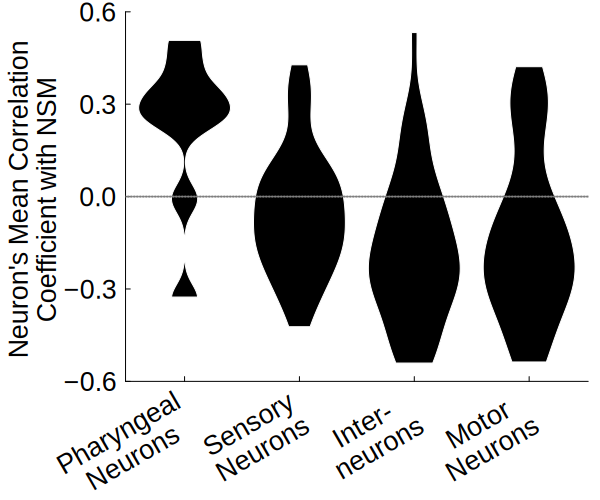

In [1373]:
Plots.plot(size=(600,500), grid=:off, fontfamily="arial", tickfontfamily="arial", guidefontsize=18, tickfontsize=18,
    xticks=([1,2,3,4], ["Pharyngeal\nNeurons", 
            "Sensory\nNeurons", 
            "Inter-\nneurons", 
            "Motor\nNeurons"]), ylabel="Neuron's Mean Correlation\nCoefficient with NSM", xrotation=30, ylims=(-0.6, 0.6), yticks=([-0.6, -0.3, 0, 0.3, 0.6]))

violin!(filter(x-> !isnan(x), list_nsm_corrcoef[pharyngeal]), label = nothing, color=:black, linecolor=:white)
violin!(filter(x-> !isnan(x), list_nsm_corrcoef[sensory]), label = nothing, color=:black, linecolor=:white)
violin!(filter(x-> !isnan(x), list_nsm_corrcoef[inter]), label = nothing, color=:black, linecolor=:white)
violin!(filter(x-> !isnan(x), list_nsm_corrcoef[motor]), label = nothing, color=:black, linecolor=:white)

hline!([0], linewidth=2, color=:grey50, linestyle=:dot, label=nothing)

In [1374]:
# General Wilcoxon test
w, p12 = stats.brunnermunzel(filter(x->!isnan(x),list_nsm_corrcoef[pharyngeal]), filter(x->!isnan(x),list_nsm_corrcoef[sensory]))
w, p13 = stats.brunnermunzel(filter(x->!isnan(x),list_nsm_corrcoef[pharyngeal]), filter(x->!isnan(x),list_nsm_corrcoef[inter]))
w, p14 = stats.brunnermunzel(filter(x->!isnan(x),list_nsm_corrcoef[pharyngeal]), filter(x->!isnan(x),list_nsm_corrcoef[motor]))
w, p23 = stats.brunnermunzel(filter(x->!isnan(x),list_nsm_corrcoef[sensory]), filter(x->!isnan(x),list_nsm_corrcoef[inter]))
w, p24 = stats.brunnermunzel(filter(x->!isnan(x),list_nsm_corrcoef[sensory]), filter(x->!isnan(x),list_nsm_corrcoef[motor]))
w, p34 = stats.brunnermunzel(filter(x->!isnan(x),list_nsm_corrcoef[inter]), filter(x->!isnan(x),list_nsm_corrcoef[motor]))
all_ps = [p12, p13, p14, p23, p24, p34]
MultipleTesting.adjust(all_ps, BenjaminiHochberg()) # list of multiple testing corrected p-values

6-element Vector{Float64}:
 0.023661944131629357
 0.00986542699251578
 0.013144308492300832
 0.023661944131629357
 0.16585040155766134
 0.6102935912672596

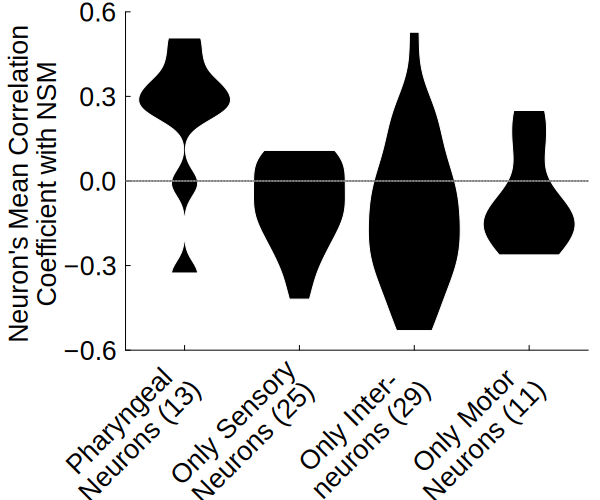

In [1375]:
# if you want to look at purely sensory, purely inter- and purely motor neurons
only_sensory = setdiff(sensory, union(intersect(sensory,inter), intersect(sensory,motor)))
only_inter = setdiff(inter, union(intersect(sensory,inter), intersect(inter,motor)))
only_motor = setdiff(motor, union(intersect(sensory,motor), intersect(inter,motor)))

Plots.plot(size=(600,500), grid=:off, fontfamily="arial", tickfontfamily="arial", guidefontsize=18, tickfontsize=18,
    xticks=([1,2,3,4], ["Pharyngeal\nNeurons ($(length(pharyngeal)))", 
            "Only Sensory\nNeurons ($(length(only_sensory)))", 
            "Only Inter-\nneurons ($(length(only_inter)))", 
            "Only Motor\nNeurons ($(length(only_motor)))"]), ylabel="Neuron's Mean Correlation\nCoefficient with NSM", xrotation=45, ylims=(-0.6, 0.6), yticks=([-0.6, -0.3, 0, 0.3, 0.6]))

violin!(filter(x-> !isnan(x), list_nsm_corrcoef[pharyngeal]), label = nothing, color=:black, linecolor=:white)
violin!(filter(x-> !isnan(x), list_nsm_corrcoef[only_sensory]), label = nothing, color=:black, linecolor=:white)
violin!(filter(x-> !isnan(x), list_nsm_corrcoef[only_inter]), label = nothing, color=:black, linecolor=:white)
violin!(filter(x-> !isnan(x), list_nsm_corrcoef[only_motor]), label = nothing, color=:black, linecolor=:white)

hline!([0], linewidth=2, color=:grey50, linestyle=:dot, label=nothing)

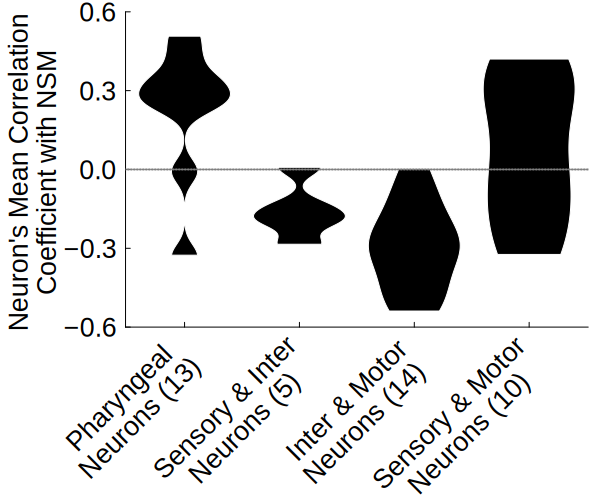

In [1376]:
# if you want to look at neurons that fall into 2 categories or more
sensory_inter = intersect(sensory,inter)
inter_motor = intersect(inter,motor)
sensory_motor = intersect(sensory,motor)

Plots.plot(size=(600,500), grid=:off, fontfamily="arial", tickfontfamily="arial", guidefontsize=18, tickfontsize=18,
    xticks=([1,2,3,4], ["Pharyngeal\nNeurons ($(length(pharyngeal)))", 
            "Sensory & Inter\nNeurons ($(length(sensory_inter)))", 
            "Inter & Motor\n Neurons ($(length(inter_motor)))", 
            "Sensory & Motor\nNeurons ($(length(sensory_motor)))"]), ylabel="Neuron's Mean Correlation\nCoefficient with NSM", xrotation=45, ylims=(-0.6, 0.6), yticks=([-0.6, -0.3, 0, 0.3, 0.6]))

violin!(filter(x-> !isnan(x), list_nsm_corrcoef[pharyngeal]), label = nothing, color=:black, linecolor=:white)
violin!(filter(x-> !isnan(x), list_nsm_corrcoef[sensory_inter]), label = nothing, color=:black, linecolor=:white)
violin!(filter(x-> !isnan(x), list_nsm_corrcoef[inter_motor]), label = nothing, color=:black, linecolor=:white)
violin!(filter(x-> !isnan(x), list_nsm_corrcoef[sensory_motor]), label = nothing, color=:black, linecolor=:white)

hline!([0], linewidth=2, color=:grey50, linestyle=:dot, label=nothing)

## Evaluate NSM correlation across neurons with different behavioral encoding - panel C

In [1378]:
# Behavioral encoding based on Aatanas et al 2022
velocity_neuron_id = ["AIB", "AIM", "ASG", "AVA", "AVB", "AVE", "AVK", "AVL", "BAG", "OLQD", "RIB", "RID", "RIM", "RIS", "RIV", "RME", "RMED", "RMEV", "SAAV", "SIAV", "SIBV", "SMDV", "URYD", "URYV"]
head_curv_neuron_id = ["RIV", "SAAD", "SAAV", "SIAD", "SIAV", "SIBV", "SMBD", "SMBV", "SMDD", "SMDV"]
feeding_neuron_id = ["M3", "M5", "MC"]

vel = findall(x-> x in velocity_neuron_id, list_class_any_dv[no_nsm_list])
head = findall(x-> x in head_curv_neuron_id, list_class_any_dv[no_nsm_list])
pump = findall(x-> x in feeding_neuron_id, list_class_any_dv[no_nsm_list])
nth = findall(x-> x ∉ union(velocity_neuron_id, head_curv_neuron_id, feeding_neuron_id), list_class_any_dv[no_nsm_list]);

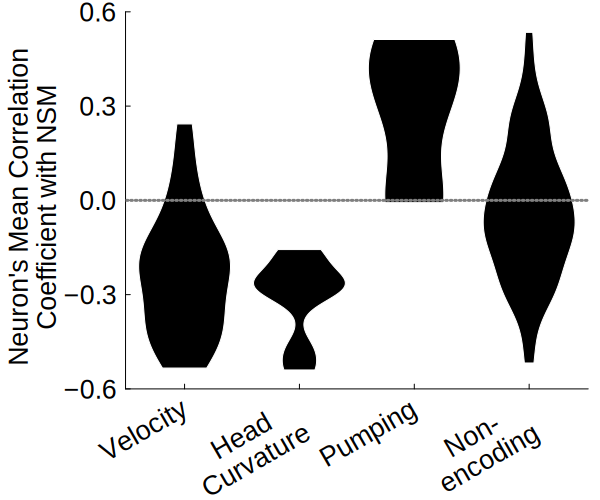

In [1379]:
Plots.plot(size=(600,500), grid=:off, fontfamily="arial", tickfontfamily="arial", guidefontsize=18, tickfontsize=18,
    xticks=(1:4, ["Velocity", "Head\nCurvature", "Pumping", "Non-\nencoding"]), ylabel="Neuron's Mean Correlation \n Coefficient with NSM", xrotation=30, ylims=(-0.6, 0.6), yticks=([-0.6, -0.3, 0, 0.3, 0.6]))
violin!(filter(x-> !isnan(x), list_nsm_corrcoef[vel]), label = nothing, color=:black, linecolor=:white)
violin!(filter(x-> !isnan(x), list_nsm_corrcoef[head]), label = nothing, color=:black, linecolor=:white)
violin!(filter(x-> !isnan(x), list_nsm_corrcoef[pump]), label = nothing, color=:black, linecolor=:white)
violin!(filter(x-> !isnan(x), list_nsm_corrcoef[nth]), label = nothing, color=:black, linecolor=:white)
hline!([0], linewidth=3, color=:grey50, linestyle=:dot, label=nothing)

In [1380]:
# General Wilcoxon test for distribution of correlation coefficients
w, p14 = stats.brunnermunzel(filter(x->!isnan(x),list_nsm_corrcoef[vel]), filter(x->!isnan(x),list_nsm_corrcoef[nth]))
w, p24 = stats.brunnermunzel(filter(x->!isnan(x),list_nsm_corrcoef[head]), filter(x->!isnan(x),list_nsm_corrcoef[nth]))
w, p34 = stats.brunnermunzel(filter(x->!isnan(x),list_nsm_corrcoef[pump]), filter(x->!isnan(x),list_nsm_corrcoef[nth]))
all_ps = [p14, p24, p34]
MultipleTesting.adjust(all_ps, BenjaminiHochberg())

3-element Vector{Float64}:
 0.00043485991498160015
 9.082489094147661e-8
 0.12996293198536843

## Evaluate NSM correlation across serotonin receptor expression - panel D-E

In [1381]:
# exclude NSM from the matrix
array_receptor_expression_dv_short = array_receptor_expression_dv[:, no_nsm_list]

6×95 Matrix{Any}:
 0  0  0  0  0  0  1  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  1  1  1  0
 0  1  0  0  0  0  0  1  0  1  1  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  1  1  0  0  0  0  1  1  0
 0  1  0  0  0  0  0  0  1  1  1  0  1     0  0  0  1  1  0  0  0  1  0  0  1
 0  1  0  0  0  0  0  1  0  1  1  1  0  …  0  0  0  0  0  0  0  0  0  0  0  0

In [1382]:
excR = findall(x->x .> 0, vec(sum(array_receptor_expression_dv_short[1:4,:], dims=1)))
inhR = findall(x->x .> 0, vec(sum(array_receptor_expression_dv_short[5:6,:], dims=1)))
no_excR = findall(x->x == 0, vec(sum(array_receptor_expression_dv_short[1:4,:], dims=1)))
no_inhR = findall(x->x == 0, vec(sum(array_receptor_expression_dv_short[5:6,:], dims=1)));

In [1383]:
# fraction of observations that a neuron is activated/ inhibited by NSM
list_fraction_NSM_inhibition = total_neg ./total_obs 
list_fraction_NSM_inhibition = list_fraction_NSM_inhibition[no_nsm_list]
list_fraction_NSM_activation = total_pos ./total_obs 
list_fraction_NSM_activation = list_fraction_NSM_activation[no_nsm_list];

In [1384]:
n_classes = length(no_nsm_list)

any_neurons = union(excR, inhR) # neurons that express at least one type of 5-HTR
alt_any_neurons = setdiff(1:n_classes, any_neurons) # every other neuron

exc_only_neurons = intersect(excR, no_inhR) # neurons that express excitatory but not inhibitory 5-HTR
alt_exc_only_neurons = setdiff(1:n_classes, exc_only_neurons) # every other neuron

inh_only_neurons = intersect(inhR, no_excR) # neurons that express inhibitory but not excitatory 5-HTR
alt_inh_only_neurons = setdiff(1:n_classes, inh_only_neurons) # every other neuron

mixed_neurons = intersect(excR, inhR) # neurons that express a mixture of excitatory and inhibitory 5-HTR
alt_mixed_neurons = setdiff(1:n_classes, mixed_neurons); # every other neuron

In [1402]:
list_groups = [any_neurons, alt_any_neurons, exc_only_neurons, alt_exc_only_neurons, inh_only_neurons, alt_inh_only_neurons, mixed_neurons, alt_mixed_neurons]
# list_outputs = [any_neurons_res, alt_any_neurons_res, exc_only_neurons_res, alt_exc_only_neurons_res, inh_only_neurons_res, alt_inh_only_neurons_res, mixed_neurons_res, alt_mixed_neurons_res]
list_outputs = []

for i in list_groups
    out = [sum(list_fraction_NSM_activation[i] .> fdr_thresh), 
        sum(list_fraction_NSM_inhibition[i] .> fdr_thresh), 
        sum(list_fraction_NSM_activation[i] .<= fdr_thresh .&& list_fraction_NSM_inhibition[i] .<= fdr_thresh)]
    push!(list_outputs, out)
end

In [1386]:
# panel E
array_plot_3 = hcat(list_outputs[1]./length(any_neurons), list_outputs[2]./length(alt_any_neurons), 
    list_outputs[3]./length(exc_only_neurons), list_outputs[4]./length(alt_exc_only_neurons), 
    list_outputs[5]./length(inh_only_neurons), list_outputs[6]./length(alt_inh_only_neurons), 
    list_outputs[7]./length(mixed_neurons), list_outputs[8]./length(alt_mixed_neurons))

# it's normal for the column sums to be less than 1 since we are missing functional information about certain neurons

3×8 Matrix{Float64}:
 0.134615  0.0232558  0.25  0.04      0.125  0.0804598  0.0416667  0.0985915
 0.442308  0.209302   0.3   0.346667  0.375  0.333333   0.583333   0.253521
 0.384615  0.511628   0.4   0.453333  0.375  0.448276   0.375      0.464789

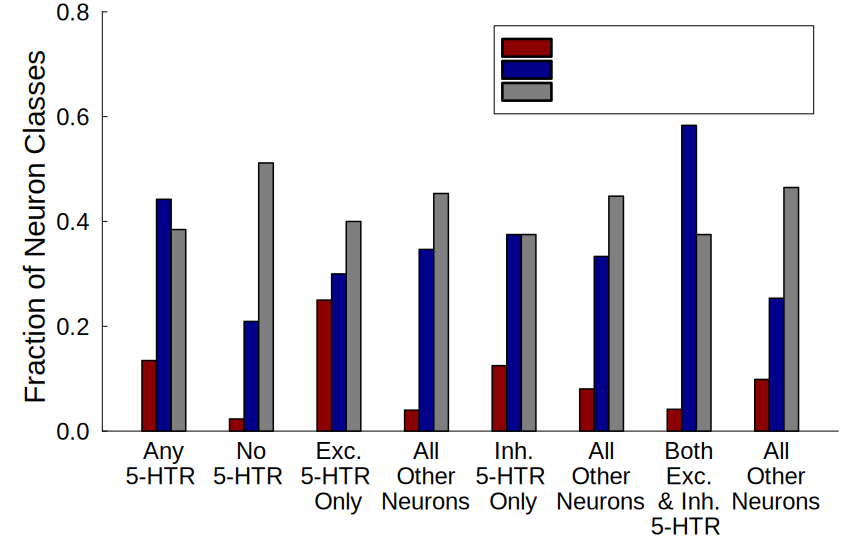

In [1387]:
ticklabel = "Any\n5-HTR", "No\n5-HTR",
            "Exc.\n5-HTR\nOnly", "All\nOther\nNeurons",
            "Inh.\n5-HTR\nOnly", "All\nOther\nNeurons",
            "Both\nExc.\n& Inh.\n5-HTR\n\n", "All\nOther\nNeurons"
groupedbar(array_plot_3',
        bar_width=0.5,
        xticks=(1:8, ticklabel),
        ytickfontsize = 16, xtickfontsize = 16,
        xrotation=0,
        label="                                          ", legend =:topright, legendfontsize=14,
        size=(850,550),
        ylabel="\nFraction of Neuron Classes",
        guidefontsize=20,
        # xlims = ((0.5,2.5)),
        ylims = ((0,0.8)),
        color = [:red4 :blue4 :grey50],
        linecolor =:black, linewidth=1.5,
        grid=:off, fontfamily="arial", tickfontfamily="arial") 

In [1388]:
# chi sq tests for distribution for each group
all_ps = zeros(0)
contingency_table = zeros(2,2)
contingency_table[1,1] = list_outputs[1][1] + list_outputs[1][2] # any 5-htr, nsm-correlated
contingency_table[1,2] = list_outputs[1][3] # any 5-htr, not nsm-correlated
contingency_table[2,1] = list_outputs[2][1] + list_outputs[2][2] # no 5-htr, nsm-correlated
contingency_table[2,2] = list_outputs[2][3] # no 5-htr, not nsm-correlated
chi2, p, dof, ex = stats.chi2_contingency(contingency_table, correction=false)
push!(all_ps, p)

1-element Vector{Float64}:
 0.01106368375707578

In [1389]:
contingency_table = zeros(2,2)
contingency_table[1,1] = list_outputs[3][1] # excitatory 5-htr only, nsm-positive correlated
contingency_table[1,2] = list_outputs[3][2] + list_outputs[3][3] # excitatory 5-htr only, not nsm-positive correlated
contingency_table[2,1] = list_outputs[4][1] # not excitatory 5-htr only, nsm-positive correlated
contingency_table[2,2] = list_outputs[4][2] + list_outputs[4][3] # not excitatory 5-htr only, not nsm-positive correlated
chi2, p, dof, ex = stats.chi2_contingency(contingency_table, correction=false)
push!(all_ps, p)

2-element Vector{Float64}:
 0.01106368375707578
 0.005514130690570577

In [1390]:
contingency_table = zeros(2,2)
contingency_table[1,1] = list_outputs[5][2] # inhibitory 5-htr only, nsm-negative correlated
contingency_table[1,2] = list_outputs[5][1] + list_outputs[5][3] # inhibitory 5-htr only, not nsm-negative correlated
contingency_table[2,1] = list_outputs[6][2] # not inhibitory 5-htr only, nsm-negative correlated
contingency_table[2,2] = list_outputs[6][1] + list_outputs[6][3] # not inhibitory 5-htr only, not nsm-positive correlated
chi2, p, dof, ex = stats.chi2_contingency(contingency_table, correction=false)
push!(all_ps, p)

3-element Vector{Float64}:
 0.01106368375707578
 0.005514130690570577
 0.8279237691572332

In [1391]:
contingency_table = zeros(2,2)
contingency_table[1,1] = list_outputs[7][2] # mixed 5-htr, nsm-negative correlated
contingency_table[1,2] = list_outputs[7][1] + list_outputs[7][3] # mixed 5-htr, not nsm-negative correlated
contingency_table[2,1] = list_outputs[8][2] # mixed 5-htr, nsm-negative correlated
contingency_table[2,2] = list_outputs[8][1] + list_outputs[8][3] # mixed 5-htr, not nsm-negative correlated
chi2, p, dof, ex = stats.chi2_contingency(contingency_table, correction=false)
push!(all_ps, p)

4-element Vector{Float64}:
 0.01106368375707578
 0.005514130690570577
 0.8279237691572332
 0.02112499242712452

In [1392]:
# correct for multiple testing
MultipleTesting.adjust(all_ps, BenjaminiHochberg())

4-element Vector{Float64}:
 0.02212736751415156
 0.02205652276228231
 0.8279237691572332
 0.028166656569499356

In [1393]:
# panel D
excR_only_neuron_id = []
inhR_only_neuron_id = []
mixedR_neuron_id = []
noR_neuron_id = []

for (i, neuron) = enumerate(list_class_any_dv)
    if neuron == "NSM"
        continue
    end
    
    if sum(exp_matrix[:, i]) > 0 # express any 5-htr
        if sum(exp_matrix[1:4, i]) > 0 # express at least one excR
            if sum(exp_matrix[5:6, i]) > 0 # express at least one inhR
                push!(mixedR_neuron_id, neuron)
            elseif sum(exp_matrix[5:6, i]) == 0 # no inhR
                push!(excR_only_neuron_id, neuron)
            end
        elseif sum(exp_matrix[5:6, i]) > 0 # express at least one inhR
            if sum(exp_matrix[1:4, i]) > 0 # express at least one excR
                push!(mixedR_neuron_id, neuron)
            elseif sum(exp_matrix[1:4, i]) == 0 # no excR
                push!(inhR_only_neuron_id, neuron)
            end
        end
    else
        push!(noR_neuron_id, neuron)
    end
end


mod_exc = 0
mod_inh = 0
mod_mixed = 0
mod_none = 0

for n in modulated_neuron_id
    if n in excR_only_neuron_id
        mod_exc = mod_exc+1
    elseif n in inhR_only_neuron_id
        mod_inh = mod_inh+1
    elseif n in mixedR_neuron_id
        mod_mixed = mod_mixed+1
    elseif n in noR_neuron_id
        mod_none = mod_none+1
    end
end

not_mod_exc = 0
not_mod_inh = 0
not_mod_mixed = 0
not_mod_none = 0

for n in not_modulated_neuron_id
    if n in excR_only_neuron_id
        not_mod_exc = not_mod_exc+1
    elseif n in inhR_only_neuron_id
        not_mod_inh = not_mod_inh+1
    elseif n in mixedR_neuron_id
        not_mod_mixed = not_mod_mixed+1
    elseif n in noR_neuron_id
        not_mod_none = not_mod_none+1
    end
end

vec_plot_1 = [mod_exc, mod_inh, mod_mixed, mod_none]' / (length(binary_modulated_obs)-1)
vec_plot_2 = [not_mod_exc, not_mod_inh, not_mod_mixed, not_mod_none]' / (length(binary_modulated_obs)-1)
array_plot = vcat(vec_plot_1, vec_plot_2)

2×4 Matrix{Float64}:
 0.158537   0.0487805  0.182927  0.158537
 0.0731707  0.0365854  0.109756  0.231707

In [1395]:
# chi sq test
contingency_table = zeros(4,2)
contingency_table[:,1] = [mod_exc, mod_inh, mod_mixed, mod_none]
contingency_table[:,2] = [not_mod_exc, not_mod_inh, not_mod_mixed, not_mod_none]

HypothesisTests.ChisqTest(Int.(contingency_table))

Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [0.127156, 0.0468471, 0.160619, 0.214158, 0.104551, 0.0385187, 0.132064, 0.176086]
    point estimate:          [0.158537, 0.0487805, 0.182927, 0.158537, 0.0731707, 0.0365854, 0.109756, 0.231707]
    95% confidence interval: [(0.06098, 0.264), (0.0, 0.1543), (0.08537, 0.2884), (0.06098, 0.264), (0.0, 0.1786), (0.0, 0.1421), (0.0122, 0.2152), (0.1341, 0.3372)]

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.2027

Details:
    Sample size:        82
    statistic:          4.610197227302489
    degrees of freedom: 3
    residuals:          [0.796879, 0.0808875, 0.504049, -1.08839, -0.878816, -0.0892045, -0.555876, 1.2003]
    std. residuals:     [1.35343, 0.125911, 0.892219, -2.07497, -1.35343, -0.125911, -0.892219, 2.07497]


In [1396]:
# instead of NSM-correlated vs not correlated, here I group neurons by positively and negatively correlated
pos_modulated_obs = zeros(length(list_class_any_dv_obs))
neg_modulated_obs = zeros(length(list_class_any_dv_obs))

for col = 1:length(list_class_any_dv_obs)
    if length(findall(x->x==1, cat_matrix_obs[:, col])) > total_obs[col]*fdr_thresh
        pos_modulated_obs[col] = 1
    end
    
    if length(findall(x->x==2, cat_matrix_obs[:, col])) > total_obs[col]*fdr_thresh
        neg_modulated_obs[col] = 1
    end
end

In [1397]:
pos_modulated_neuron_id = list_class_any_dv_obs[findall(x->x==1, pos_modulated_obs)]
neg_modulated_neuron_id = list_class_any_dv_obs[findall(x->x==1, neg_modulated_obs)];
pos_modulated_neuron_id = filter(x->x != "NSM", pos_modulated_neuron_id);

In [1398]:
pos_mod_exc = 0
pos_mod_inh = 0
pos_mod_mixed = 0
pos_mod_none = 0

for n in pos_modulated_neuron_id
    if n in excR_only_neuron_id
        pos_mod_exc = pos_mod_exc+1
    elseif n in inhR_only_neuron_id
        pos_mod_inh = pos_mod_inh+1
    elseif n in mixedR_neuron_id
        pos_mod_mixed = pos_mod_mixed+1
    elseif n in noR_neuron_id
        pos_mod_none = pos_mod_none+1
    end
end

neg_mod_exc = 0
neg_mod_inh = 0
neg_mod_mixed = 0
neg_mod_none = 0

for n in neg_modulated_neuron_id
    if n in excR_only_neuron_id
        neg_mod_exc = neg_mod_exc+1
    elseif n in inhR_only_neuron_id
        neg_mod_inh = neg_mod_inh+1
    elseif n in mixedR_neuron_id
        neg_mod_mixed = neg_mod_mixed+1
    elseif n in noR_neuron_id
        neg_mod_none = neg_mod_none+1
    end
end

vec_plot_01 = [pos_mod_exc, pos_mod_inh, pos_mod_mixed, pos_mod_none]' / (length(binary_modulated_obs)-1)
vec_plot_02 = [neg_mod_exc, neg_mod_inh, neg_mod_mixed, neg_mod_none]' / (length(binary_modulated_obs)-1)
array_plot_0 = vcat(vec_plot_01, vec_plot_02, vec_plot_2)

3×4 Matrix{Float64}:
 0.0731707  0.0121951  0.0121951  0.0243902
 0.097561   0.0365854  0.170732   0.109756
 0.0731707  0.0365854  0.109756   0.231707

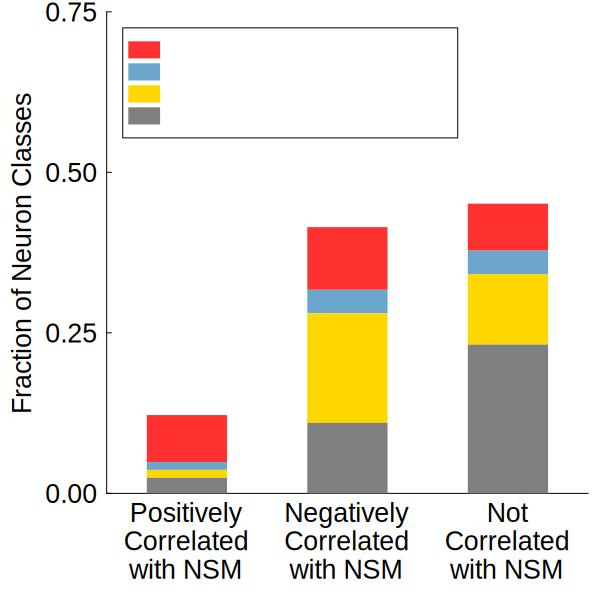

In [1399]:
ticklabel = "Positively\nCorrelated\nwith NSM", "Negatively\nCorrelated\nwith NSM", "Not\nCorrelated\nwith NSM"
groupedbar(array_plot_0,
        bar_position = :stack,
        bar_width=0.5,
        xticks=(1:3, ticklabel),
        yticks=([0, 0.25, 0.5, 0.75]),
        ytickfontsize = 18, xtickfontsize = 18,
        xrotation=0,
        label="                                                 ", legend =:topleft, legendfontsize=14,
        size=(600,600),
        ylabel="Fraction of Neuron Classes",
        guidefontsize=18,
        xlims = ((0.5,3.5)),
        ylims = ((0,0.75)),
        color = [:firebrick1 :skyblue3 :gold :grey50],
        linecolor =:white, linewidth=0,
        grid=:off, fontfamily="arial", tickfontfamily="arial") 

In [1400]:
contingency_table = zeros(4,3)
contingency_table[:,1] = [pos_mod_exc, pos_mod_inh, pos_mod_mixed, pos_mod_none]
contingency_table[:,2] = [neg_mod_exc, neg_mod_inh, neg_mod_mixed, neg_mod_none]
contingency_table[:,3] = [not_mod_exc, not_mod_inh, not_mod_mixed, not_mod_none]

HypothesisTests.ChisqTest(Int.(contingency_table))

Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [0.0304832, 0.0106691, 0.0365798, 0.0457247, 0.103643, 0.036275, 0.124371, 0.155464, 0.112788, 0.0394757, 0.135345, 0.169182]
    point estimate:          [0.0740741, 0.0123457, 0.0123457, 0.0246914, 0.0987654, 0.037037, 0.17284, 0.111111, 0.0740741, 0.037037, 0.111111, 0.234568]
    95% confidence interval: [(0.0, 0.183), (0.0, 0.1213), (0.0, 0.1213), (0.0, 0.1336), (0.01235, 0.2077), (0.0, 0.146), (0.08642, 0.2818), (0.02469, 0.22), (0.0, 0.183), (0.0, 0.146), (0.02469, 0.22), (0.1481, 0.3435)]

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           0.0397

Details:
    Sample size:        81
    statistic:          13.216401885078358
    degrees of freedom: 6
    residuals:          [2.24703, 0.146083, -1.14038, -0.88527, -0.136349, 0.0360113, 1.23691, -1.0124, -1.03747, -0.110466, -0.592855, 1

## Evaluate NSM correlation across sources of synaptic inputs - panel F-I

In [1215]:
# make a dictionary that contains information on the fraction of presynaptic inputs that come from neurons that are correlated to NSM
synaptic_input_dict = Dict()
for neuron in list_class_any_dv[no_nsm_list]
    list_neurons = [neuron, neuron*"L", neuron*"R"]
    modulated_input_all = zeros(0)
    all_input_all = zeros(0)
    
    for data = [data_connectome1, data_connectome2, data_connectome_white]
        presynaptic_partner_dict = findPresynapticPartners(list_neurons, data) #########
        modulated_input, all_input = quantifySynapticInputModulated(presynaptic_partner_dict, modulated_neuron_id)
        push!(modulated_input_all, modulated_input)
        push!(all_input_all, all_input)
    end
    
    synaptic_input_dict[neuron] = Dict()
    synaptic_input_dict[neuron]["modulated_input_all"] = modulated_input_all
    synaptic_input_dict[neuron]["all_input_all"] = all_input_all
end

I1 has no presynaptic partners
I1 has no presynaptic partners
I2 has no presynaptic partners
I2 has no presynaptic partners
I3 has no presynaptic partners
I3 has no presynaptic partners
I4 has no presynaptic partners
I4 has no presynaptic partners
I5 has no presynaptic partners
I5 has no presynaptic partners
I6 has no presynaptic partners
I6 has no presynaptic partners
IL2D has no presynaptic partners
M1 has no presynaptic partners
M1 has no presynaptic partners
M2 has no presynaptic partners
M2 has no presynaptic partners
M3 has no presynaptic partners
M3 has no presynaptic partners
M4 has no presynaptic partners
M4 has no presynaptic partners
M5 has no presynaptic partners
M5 has no presynaptic partners
MC has no presynaptic partners
MC has no presynaptic partners
MI has no presynaptic partners
MI has no presynaptic partners
SABV has no presynaptic partners
SABV has no presynaptic partners
VB02 has no presynaptic partners
VB02 has no presynaptic partners
VB02 has no presynaptic partn

In [1216]:
# convert the info in the dictionary to a list for plotting
list_synaptic_input_modulation = zeros(length(synaptic_input_dict))
for (i,neuron) = enumerate(list_class_any_dv[no_nsm_list])
# for (i,neuron) = enumerate(setdiff(list_class_any_dv, pharyngeal_neuron_id))
    if sum(synaptic_input_dict[neuron]["all_input_all"])>0
        frac_witvliet_7 = synaptic_input_dict[neuron]["modulated_input_all"][1]/synaptic_input_dict[neuron]["all_input_all"][1]
        frac_witvliet_8 = synaptic_input_dict[neuron]["modulated_input_all"][2]/synaptic_input_dict[neuron]["all_input_all"][2]
        frac_white = synaptic_input_dict[neuron]["modulated_input_all"][3]/synaptic_input_dict[neuron]["all_input_all"][3]
        list_synaptic_input_modulation[i] = nanmean([frac_witvliet_7, frac_witvliet_8, frac_white])
    else
        list_synaptic_input_modulation[i] = NaN
    end
end

In [1217]:
receptor_neuron_id = intersect(list_class_any_dv, receptor_expressing_neurons_dv);

In [1218]:
# make a dictionary that contains information on the fraction of presynaptic inputs that come from neurons expressing a 5-HTR
receptor_input_dict = Dict()

for neuron in list_class_any_dv[no_nsm_list]
    list_neurons = [neuron, neuron*"L", neuron*"R"]
    modulated_input_all = zeros(0)
    all_input_all = zeros(0)
    
    for data = [data_connectome1, data_connectome2, data_connectome_white]
        presynaptic_partner_dict = findPresynapticPartners(list_neurons, data)
        modulated_input, all_input = quantifySynapticInputReceptor(presynaptic_partner_dict, receptor_expressing_neurons_dv) #######
        push!(modulated_input_all, modulated_input)
        push!(all_input_all, all_input)
    end
    
    receptor_input_dict[neuron] = Dict()
    receptor_input_dict[neuron]["modulated_input_all"] = modulated_input_all
    receptor_input_dict[neuron]["all_input_all"] = all_input_all
end

I1 has no presynaptic partners
I1 has no presynaptic partners
I2 has no presynaptic partners
I2 has no presynaptic partners
I3 has no presynaptic partners
I3 has no presynaptic partners
I4 has no presynaptic partners
I4 has no presynaptic partners
I5 has no presynaptic partners
I5 has no presynaptic partners
I6 has no presynaptic partners
I6 has no presynaptic partners
IL2D has no presynaptic partners
M1 has no presynaptic partners
M1 has no presynaptic partners
M2 has no presynaptic partners
M2 has no presynaptic partners
M3 has no presynaptic partners
M3 has no presynaptic partners
M4 has no presynaptic partners
M4 has no presynaptic partners
M5 has no presynaptic partners
M5 has no presynaptic partners
MC has no presynaptic partners
MC has no presynaptic partners
MI has no presynaptic partners
MI has no presynaptic partners
SABV has no presynaptic partners
SABV has no presynaptic partners
VB02 has no presynaptic partners
VB02 has no presynaptic partners
VB02 has no presynaptic partn

In [1223]:
list_receptor_modulation = zeros(length(receptor_input_dict))
for (i,neuron) = enumerate(list_class_any_dv[no_nsm_list])  
    if sum(receptor_input_dict[neuron]["all_input_all"])>0
        frac_witvliet_7 = receptor_input_dict[neuron]["modulated_input_all"][1]/receptor_input_dict[neuron]["all_input_all"][1]
        frac_witvliet_8 = receptor_input_dict[neuron]["modulated_input_all"][2]/receptor_input_dict[neuron]["all_input_all"][2]
        frac_white = receptor_input_dict[neuron]["modulated_input_all"][3]/receptor_input_dict[neuron]["all_input_all"][3]
        list_receptor_modulation[i] = nanmean([frac_witvliet_7, frac_witvliet_8, frac_white])
    else
        list_receptor_modulation[i] = NaN
    end
end

In [1224]:
# since we are looking at correlation strength here, we take the absolute value for correlation coefficients
list_nsm_corrcoef_abs = abs.(list_nsm_corrcoef); 

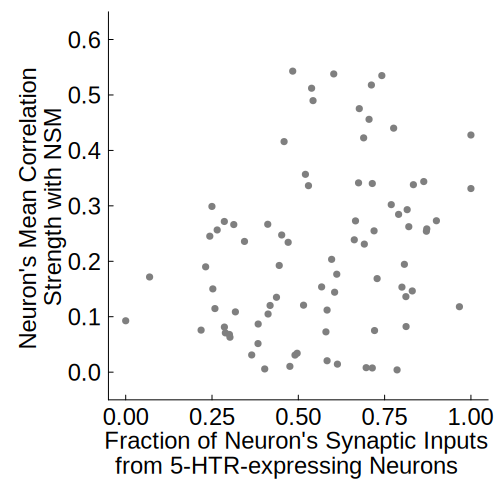

In [1416]:
# make scatter plot in panel F
xs = list_receptor_modulation
ys = list_nsm_corrcoef_abs

Plots.scatter(xs, ys, markersize=4, markercolor=:grey50, markerstrokewidth=0, label=nothing, size=(500,500), grid=:off,
    xlims=(-0.05,1.05), ylims=(-0.05,0.65), xlabel="Fraction of Neuron's Synaptic Inputs\n from 5-HTR-expressing Neurons", 
    ylabel="Neuron's Mean Correlation\nStrength with NSM",
    fontfamily="arial", guidefontsize=16, tickfontsize=16)

In [1260]:
filt = findall(x -> !isnan(x), xs .+ ys)
Y = ys[filt]
X = xs[filt]

line = Polynomials.fit(X,Y,1)

Polynomial(0.10879741119941241 + 0.1897892993611442*x)

In [1261]:
df = DataFrame(X = X, Y = Y)
fm = @formula(Y ~ X)
@time(model = lm(fm, df))

  0.000122 seconds (164 allocations: 18.359 KiB)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
───────────────────────────────────────────────────────────────────────
                Coef.  Std. Error     t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────
(Intercept)  0.108797   0.0433636  2.51    0.0142  0.0224844   0.19511
X            0.189789   0.071282   2.66    0.0094  0.047906    0.331673
───────────────────────────────────────────────────────────────────────

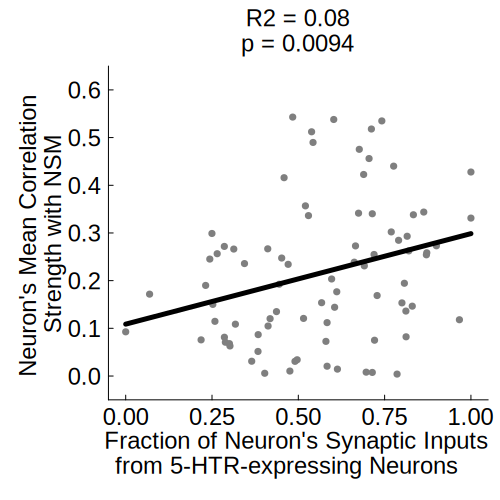

In [1262]:
ypred = 0.1897892993611442.*X .+ 0.10879741119941241
R2 = 1 - sum((ypred.-Y).^2)/sum((Y.-mean(Y)).^2)
plot!(X, ypred, linewidth=5, color=:black, label=nothing, title="R2 = $(round(R2; digits=2))\np = $(0.0094)", titlefontsize=16)

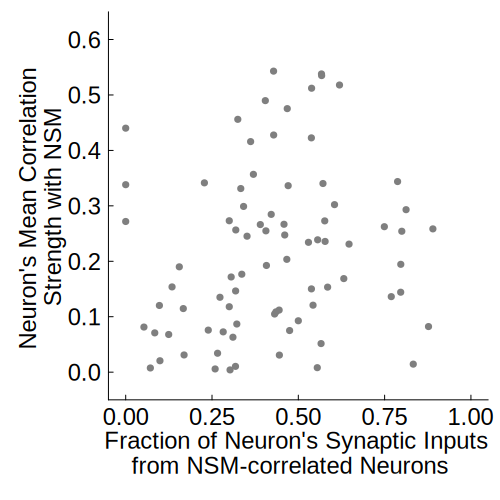

In [1263]:
# make scatter plot in panel G
xs = list_synaptic_input_modulation
ys = list_nsm_corrcoef_abs

Plots.scatter(xs, ys, markersize=4, markercolor=:grey50, markerstrokewidth=0, label=nothing, size=(500,500), grid=:off,
    xlims=(-0.05,1.05), ylims=(-0.05,0.65), xlabel="Fraction of Neuron's Synaptic Inputs\n from NSM-correlated Neurons", 
    ylabel="Neuron's Mean Correlation\nStrength with NSM",
    fontfamily="arial", guidefontsize=16, tickfontsize=16)

In [1265]:
filt = findall(x -> !isnan(x), xs .+ ys)
Y = ys[filt]
X = xs[filt]
line = Polynomials.fit(X,Y,1)

Polynomial(0.1657883251965153 + 0.11910804702689115*x)

In [1266]:
df = DataFrame(X = X, Y = Y)
fm = @formula(Y ~ X)
@time(model = lm(fm, df))

  0.000145 seconds (164 allocations: 18.359 KiB)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error     t  Pr(>|t|)   Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  0.165788   0.0359441  4.61    <1e-04   0.0942434   0.237333
X            0.119108   0.0756246  1.57    0.1193  -0.031419    0.269635
────────────────────────────────────────────────────────────────────────

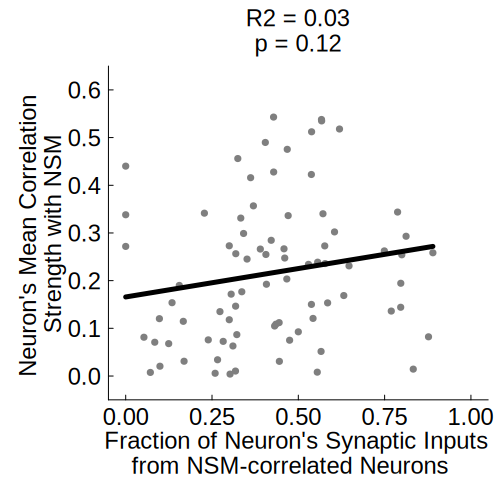

In [1267]:
ypred = 0.11910804702689115.*X .+ 0.1657883251965153
R2 = 1 - sum((ypred.-Y).^2)/sum((Y.-mean(Y)).^2)
plot!(X, ypred, linewidth=5, color=:black, label=nothing, title="R2 = $(round(R2; digits=2))\np = $(0.12)", titlefontsize=16)